In [1]:
import os
import cmdstanpy
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import describe, gaussian_kde, norm, expon
import multiprocessing
import seaborn as sns
import warnings
import time

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 14

In [20]:
from thinning import sample_hawkes_process_thinning_true_vectorised
from utils import exp_kernel_vectorised, constant_background, plot_counting_process
from mle import log_likelihood
from utils import trace_plots, posterior_histograms, posterior_kdes_overlaid, stacked_credible_intervals

In [6]:
np.random.SeedSequence()

SeedSequence(
    entropy=27328568647107185117116110580950121527,
)

In [7]:
param_strings = ['mu', 'alpha', 'delta']

# Bayesian inference

## Testing code and verifying correctness

We will compile our first Stan model to check Bayesian inference is working and that the MCMC sampler is converging.

The model includes the log-likelihood as a 'generated quantity' so that we can check that our Stan and Python implementations of the log-likelihood function agree.

In [8]:
stan_file = os.path.join('.', 'models', 'normal_priors_with_log_lik.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

We run the following line to check the model is compiled properly.

In [9]:
model_compiled.exe_info()

{'stan_version_major': '2',
 'stan_version_minor': '34',
 'stan_version_patch': '1',
 'STAN_THREADS': 'true',
 'STAN_MPI': 'false',
 'STAN_OPENCL': 'false',
 'STAN_NO_RANGE_CHECKS': 'false',
 'STAN_CPP_OPTIMS': 'false'}

Next, we simulate some data and put it in the right format for the Stan model.

In [10]:
hawkes_seed=81123867819014675093953765794895738137

max_T = 100
hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=hawkes_seed)
N = len(hawkes_realisation)

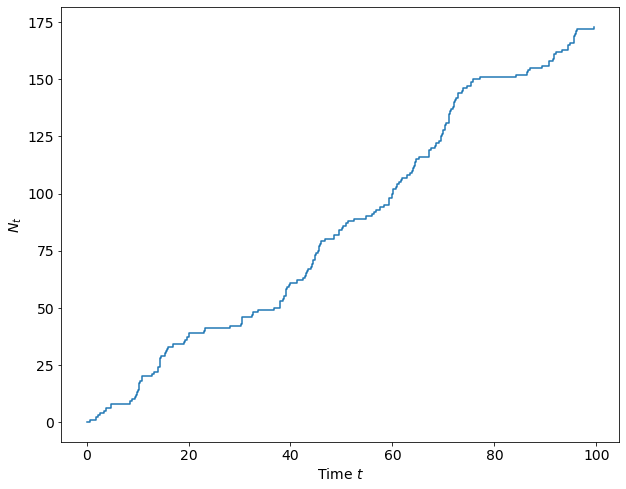

In [11]:
plot_counting_process(hawkes_realisation)

In [12]:
data = {
    "N" : N,
    "events_list" : hawkes_realisation,
    "max_T" : max_T
}

Now we run the MCMC sampler.

In [13]:
warmup = 250

fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits="0",
                            save_warmup=True)

10:33:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

10:34:20 - cmdstanpy - INFO - CmdStan done processing.


We call the following methods to ensure the sampler converged properly and ran into no big errors.

In [14]:
fit.summary()

Mean      MCSE  ...  N_Eff/s     R_hat
lp__                  -59.860700  0.051784  ...  18.2017  1.001610
mu                      0.842478  0.005735  ...  26.5113  0.999813
alpha                   0.967399  0.009989  ...  20.0656  1.003430
delta                   1.875570  0.020692  ...  19.6348  1.004070
hawkes_log_likelihood -59.997100  0.044185  ...  20.3537  1.001170

[5 rows x 9 columns]

The large N_Eff values and R_hat values close to 1 are reassuring.

In [15]:
print(fit.diagnose())

Processing csv files: C:\Users\ethan\AppData\Local\Temp\tmpjlym7j_h\normal_priors_with_log_lik47k6dxlu\normal_priors_with_log_lik-20240425103358_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\AppData\Local\Temp\tmpjlym7j_h\normal_priors_with_log_lik47k6dxlu\normal_priors_with_log_lik-20240425103358_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



As is the output from the diagnose method.

Next we examine the trace plot, including the warmup (or `burn in') to check that the chains have mixed.

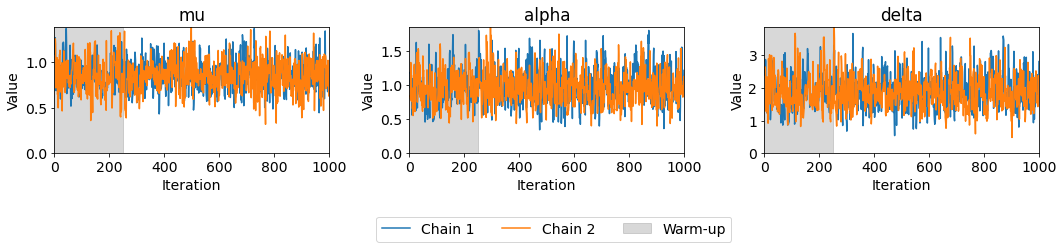

In [83]:
trace_plots([fit], param_strings, warmup=warmup)

We see the 'fuzzy caterpillar' that indicates good mixing, and can safely conclude that the posteriors have been sufficiently explored.

We can also do pair plots to examine convergence.

In [84]:
key_parameters_df = fit.draws_pd(['mu', 'alpha', 'delta', 'lp__'])

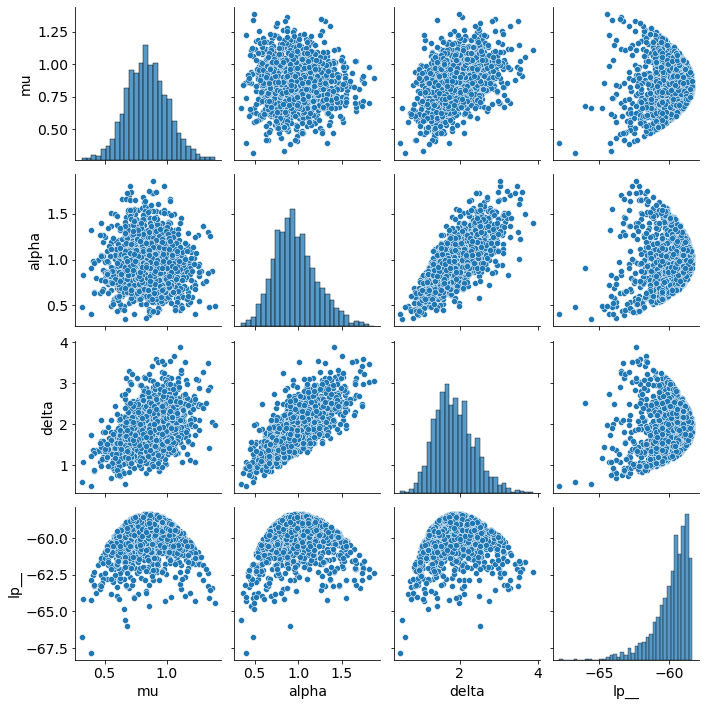

In [85]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    sns.pairplot(key_parameters_df)
plt.show()

There is no clear correlation between variables, which is reassuring.

Finally, we check that the log-likelihood functions agree by comparing the outputs of the Stan function with the outputs of the Python function.

In [86]:
df = fit.draws_pd(inc_warmup=True)

In [87]:
log_lik_via_python = []

for index, row in df.iterrows():

    mu = row['mu']
    alpha = row['alpha']
    delta = row['delta']

    params = mu, alpha, delta

    log_lik_via_python.append(log_likelihood(params, [hawkes_realisation, max_T]))

In [88]:
np.allclose(np.array(log_lik_via_python), df['hawkes_log_likelihood'].values)

True

They are, so we can safely assume that our Stan function works correctly in all future experiments.

We plot the posterior distributions (as histograms and KDEs) with the prior density overlaid.

In [89]:
mu_prior = lambda x: norm.pdf(x, loc=1, scale=1**2)
alpha_prior = lambda x: norm.pdf(x, loc=1, scale=1**2)
delta_prior = lambda x: norm.pdf(x, loc=2, scale=1**2)

prior_funcs = [mu_prior, alpha_prior, delta_prior]

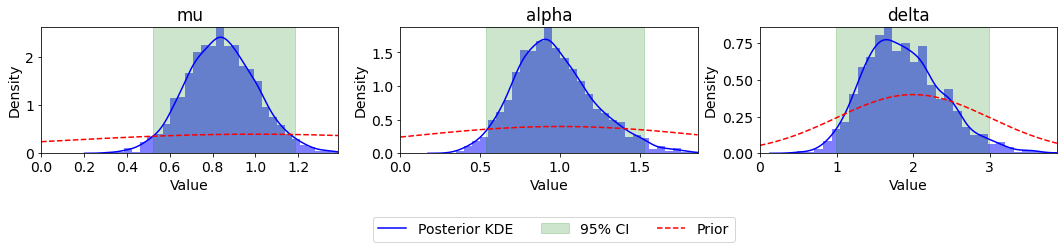

In [90]:
posterior_histograms([fit], param_strings, prior_funcs)

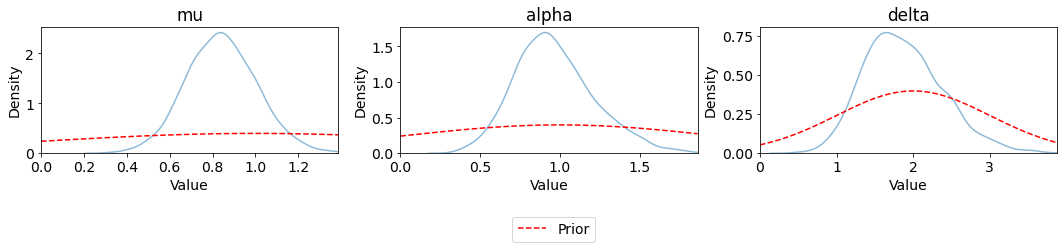

In [91]:
posterior_kdes_overlaid([fit], param_strings, prior_funcs)

And credible intervals.

In [92]:
mu_prior_ci = stats.norm.interval(0.95, loc=1, scale=1**2)
alpha_prior_ci = stats.norm.interval(0.95, loc=1, scale=1**2)
delta_prior_ci = stats.norm.interval(0.95, loc=2, scale=1**2)

prior_cis = [mu_prior_ci, alpha_prior_ci, delta_prior_ci]

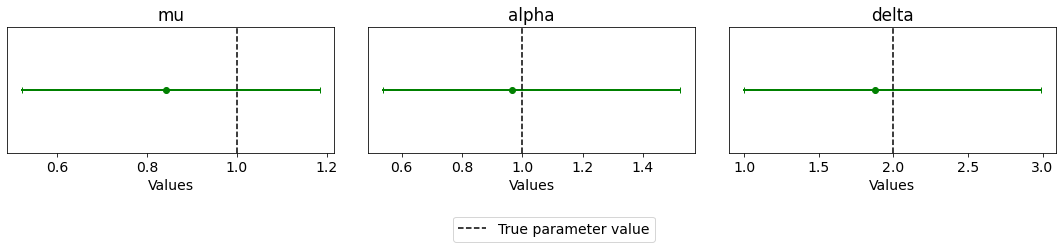

In [98]:
stacked_credible_intervals([fit], param_strings, [1,1,2])

## Experiments

Now we are ready to run some experiments. Firstly we will compare setting informative versus weakly informative priors.

First we generate a dataset of 10 realisation up to time 100, to use for both prior settings.

In [99]:
max_T = 100
num_samples = 10
hawkes_realisations = []

master_seed = 37789148086743724264404479032151903001
seed_seq_master = np.random.SeedSequence(master_seed)

for i in range(num_samples):

    child_seed = seed_seq_master.spawn(1)[0]

    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=child_seed)
    hawkes_realisations.append(hawkes_realisation)

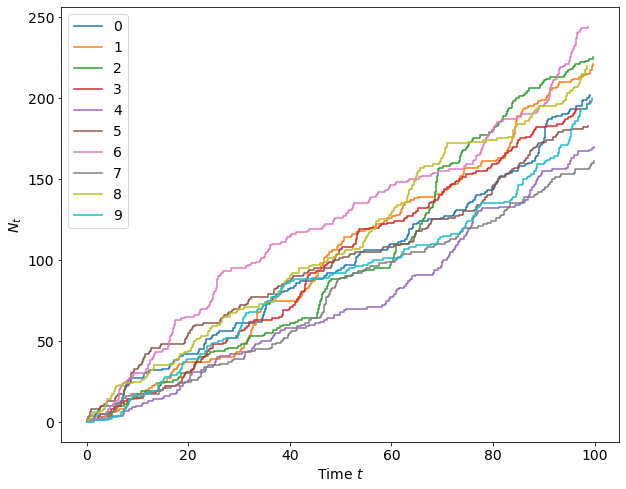

In [144]:
for i, h in enumerate(hawkes_realisations):
    h = [0] + h
    counts = np.arange(len(h))
    plt.step(h, counts, where='post', label=i)
plt.xlabel("Time $t$")
plt.ylabel("$N_t$")
plt.legend()
plt.show()

In [112]:
data_list = [{
    "N" : len(h),
    "events_list" : h,
    "max_T" : max_T
} for h in hawkes_realisations]

### Informative priors - Normal with variance 1

In [107]:
stan_file = os.path.join('.', 'models', 'normal_priors.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

14:56:14 - cmdstanpy - INFO - compiling stan file C:\Users\ethan\ONEDRI~1\Maths\YEAR4~1\Project\HAWKES~1\BAYESI~1\models\normal_priors.stan to exe file C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\normal_priors.exe
14:56:30 - cmdstanpy - INFO - compiled model executable: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\normal_priors.exe


In [115]:
warmup = 250

master_seed_stan = 74400201813715236467308085794042177128
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits = []

save_dir = os.path.join('.', 'saved_fits', 'normal_priors')

for i in range(num_samples):
    print(f"MCMC sampling for realisation {i}")

    child_seed_stan = seed_seq_master_stan.spawn(1)[0]

    # Create a random number generator using the seed
    rng = np.random.default_rng(child_seed_stan)
    
    # Generate random integers less than 2**32 - 1
    child_seed = rng.integers(2**32 - 1)
    print(f"Child seed used = {child_seed}")

    save_path = os.path.join(save_dir, f"realisation{i}")
    print(f"Saving to {save_path}")

    fit = model_compiled.sample(data=data_list[i],
                                seed=child_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True,
                                output_dir=save_path)
    
    fits.append(fit)

15:09:09 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\realisation0
15:09:09 - cmdstanpy - INFO - CmdStan start processing


MCMC sampling for realisation 0
Child seed used = 308621210
Saving to .\saved_fits\realisation0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:09:38 - cmdstanpy - INFO - CmdStan done processing.
15:09:38 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\realisation1
15:09:38 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 1
Child seed used = 4014884693
Saving to .\saved_fits\realisation1


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:10:34 - cmdstanpy - INFO - CmdStan done processing.
15:10:34 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\realisation2
15:10:34 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 2
Child seed used = 4154317557
Saving to .\saved_fits\realisation2


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:11:07 - cmdstanpy - INFO - CmdStan done processing.
15:11:07 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\realisation3
15:11:07 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 3
Child seed used = 796872812
Saving to .\saved_fits\realisation3


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:11:32 - cmdstanpy - INFO - CmdStan done processing.
15:11:32 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\realisation4



MCMC sampling for realisation 4
Child seed used = 2419664284
Saving to .\saved_fits\realisation4


15:11:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:11:53 - cmdstanpy - INFO - CmdStan done processing.
15:11:53 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\realisation5
15:11:53 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 5
Child seed used = 1279310219
Saving to .\saved_fits\realisation5


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:13:00 - cmdstanpy - INFO - CmdStan done processing.
15:13:00 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\realisation6
15:13:00 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 6
Child seed used = 3359125489
Saving to .\saved_fits\realisation6


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:13:48 - cmdstanpy - INFO - CmdStan done processing.
15:13:49 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\realisation7
15:13:49 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 7
Child seed used = 1582331695
Saving to .\saved_fits\realisation7


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:14:13 - cmdstanpy - INFO - CmdStan done processing.
15:14:13 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\realisation8
15:14:13 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 8
Child seed used = 1117257761
Saving to .\saved_fits\realisation8


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:15:25 - cmdstanpy - INFO - CmdStan done processing.
15:15:25 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\realisation9
15:15:25 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 9
Child seed used = 1370886170
Saving to .\saved_fits\realisation9


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:16:01 - cmdstanpy - INFO - CmdStan done processing.


In [102]:
fits = []

save_dir = os.path.join('.', 'saved_fits', 'normal_priors')

for i in range(num_samples):
    save_path = os.path.join(save_dir, f"realisation{i}")
    fit = cmdstanpy.from_csv(save_path)
    fits.append(fit)

In [103]:
for i in range(num_samples):
    print(fits[i].summary())
    print(fits[i].diagnose())

           Mean      MCSE    StdDev  ...    N_Eff  N_Eff/s     R_hat
lp__  -30.41940  0.055551  1.311660  ...  557.521  11.9694  1.000330
mu      1.06669  0.006518  0.164388  ...  636.024  13.6547  1.005230
alpha   1.39457  0.010941  0.295198  ...  727.897  15.6271  1.000760
delta   2.94037  0.020886  0.579674  ...  770.311  16.5377  0.999482

[4 rows x 9 columns]
Processing csv files: .\saved_fits\normal_priors\realisation0\normal_priors-20240422150909_1.csvWarning: non-fatal error reading adaptation data
, .\saved_fits\normal_priors\realisation0\normal_priors-20240422150909_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no probl

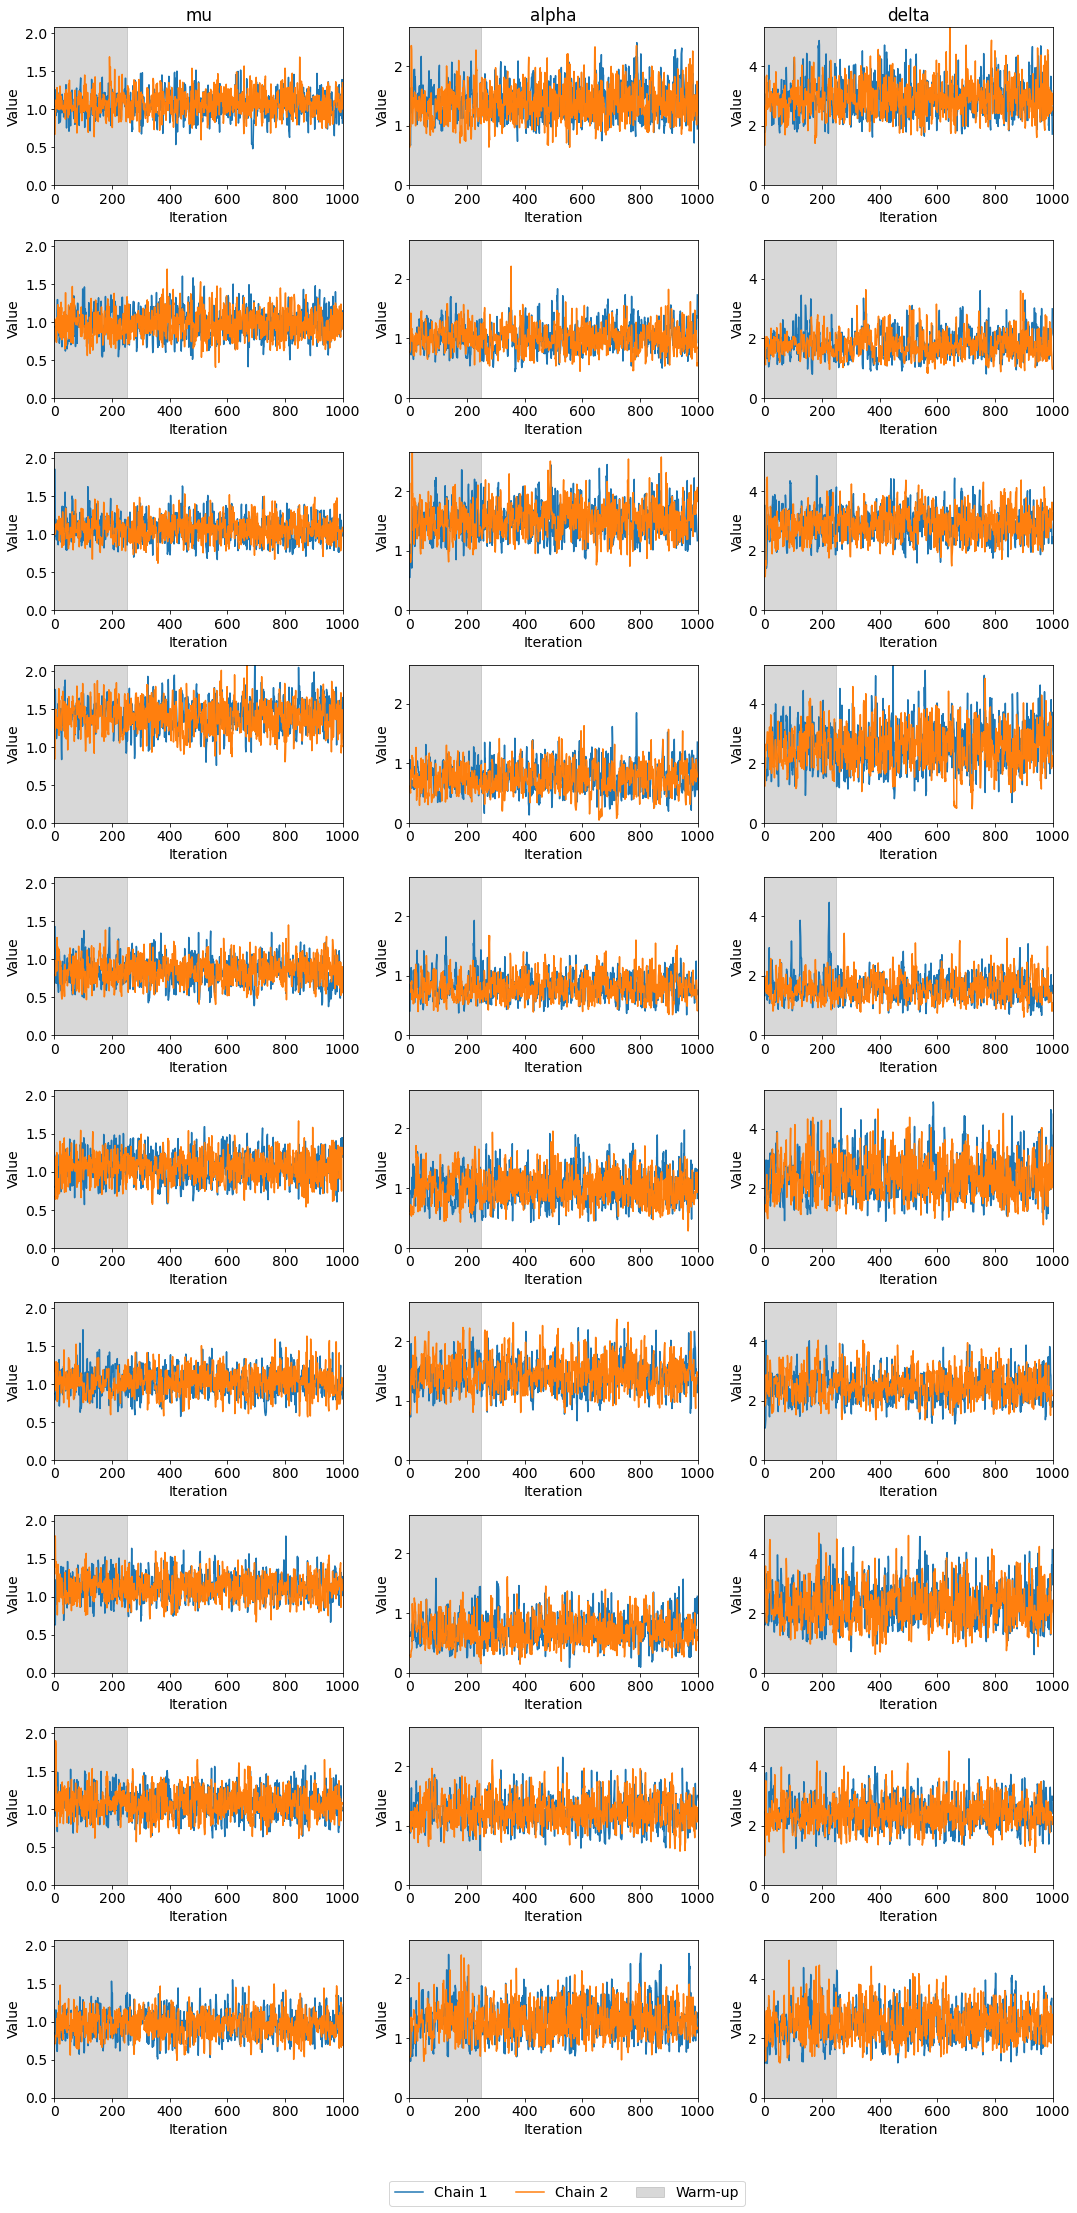

In [104]:
trace_plots(fits, param_strings, warmup=warmup)

In [105]:
mu_prior = lambda x: norm.pdf(x, loc=1, scale=1**2)
alpha_prior = lambda x: norm.pdf(x, loc=1, scale=1**2)
delta_prior = lambda x: norm.pdf(x, loc=2, scale=1**2)

prior_funcs = [mu_prior, alpha_prior, delta_prior]

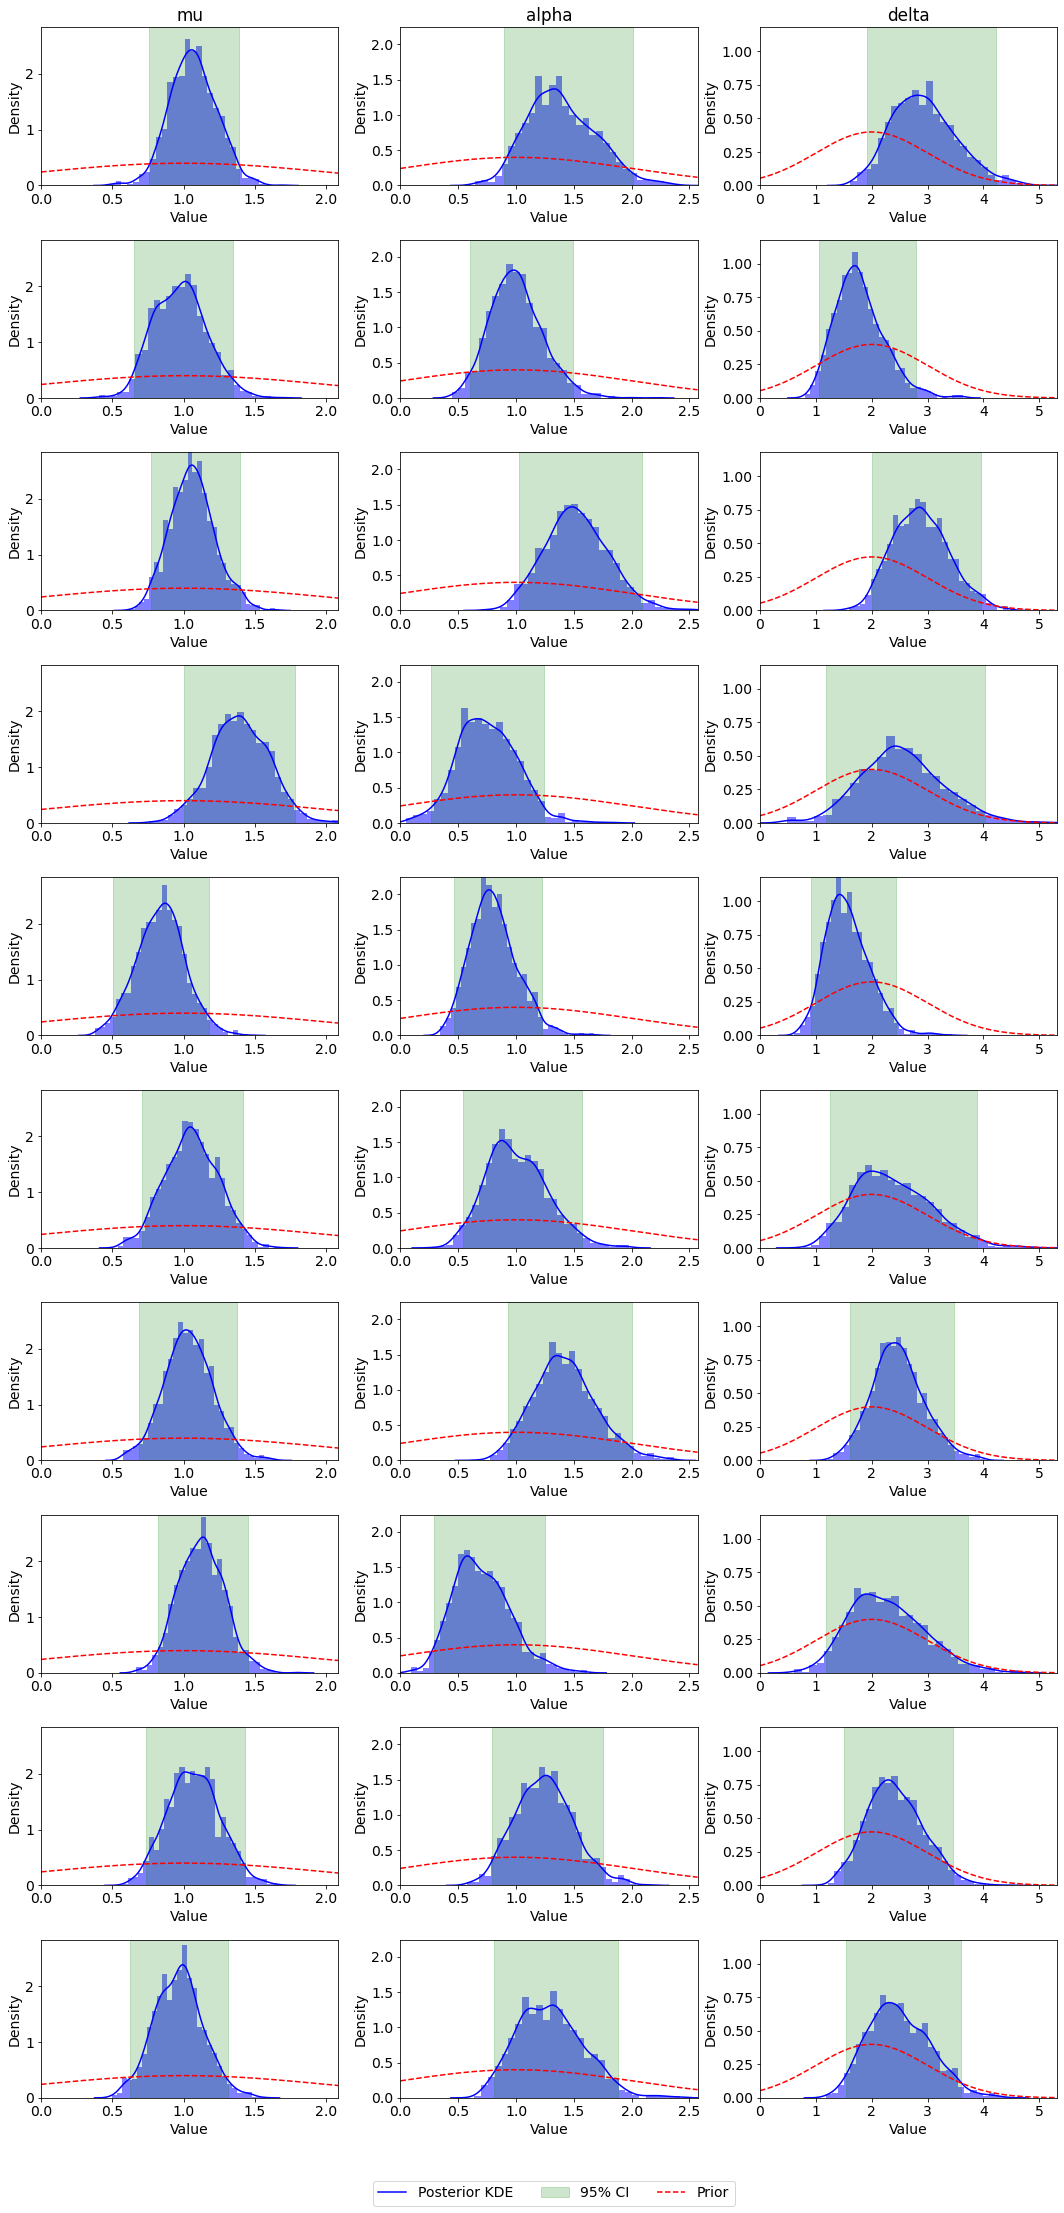

In [106]:
posterior_histograms(fits, param_strings, prior_funcs)

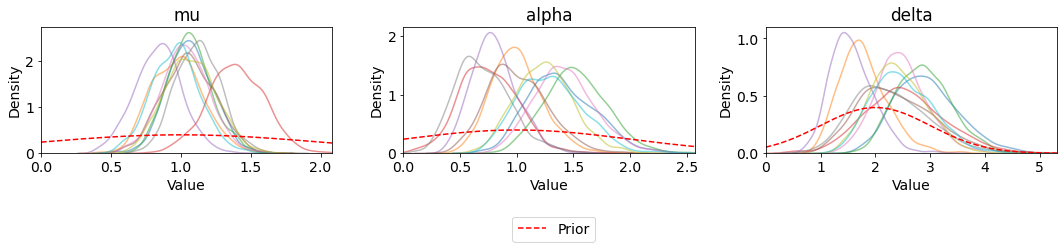

In [107]:
posterior_kdes_overlaid(fits, param_strings, prior_funcs)

In [108]:
mu_prior_ci = stats.norm.interval(0.95, loc=1, scale=1**2)
alpha_prior_ci = stats.norm.interval(0.95, loc=1, scale=1**2)
delta_prior_ci = stats.norm.interval(0.95, loc=2, scale=1**2)

prior_cis = [mu_prior_ci, alpha_prior_ci, delta_prior_ci]

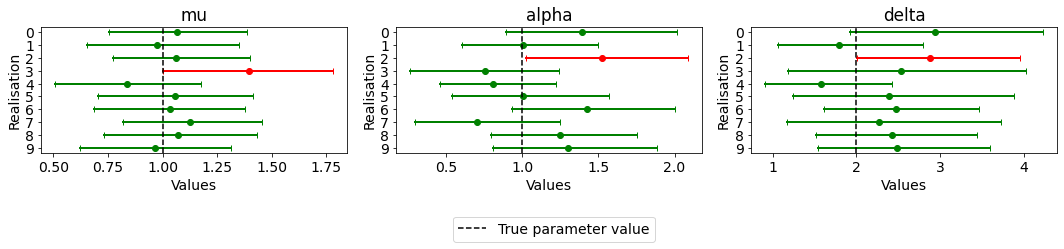

In [109]:
stacked_credible_intervals(fits, param_strings, [1,1,2])

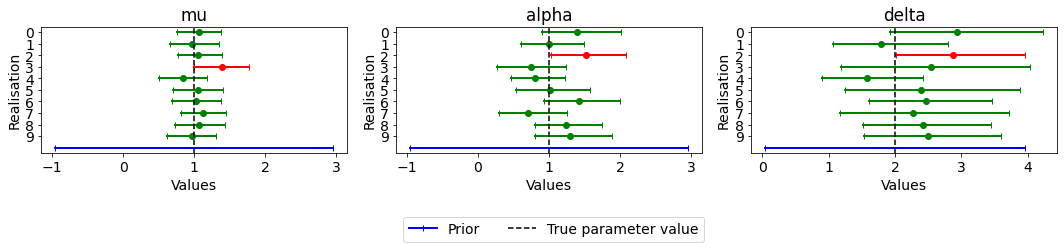

In [110]:
stacked_credible_intervals(fits, param_strings, [1,1,2], prior_cis)

### Weakly informative priors - Exponential(0.01)

In [150]:
stan_file = os.path.join('.', 'models', 'exponential_priors.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

15:28:30 - cmdstanpy - INFO - compiling stan file C:\Users\ethan\ONEDRI~1\Maths\YEAR4~1\Project\HAWKES~1\BAYESI~1\models\exponential_priors.stan to exe file C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\exponential_priors.exe
15:28:46 - cmdstanpy - INFO - compiled model executable: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\exponential_priors.exe


In [151]:
warmup = 250

master_seed_stan = 74400201813715236467308085794042177128
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits = []

save_dir = os.path.join('.', 'saved_fits', 'exponential_priors')

for i in range(num_samples):
    print(f"MCMC sampling for realisation {i}")

    child_seed_stan = seed_seq_master_stan.spawn(1)[0]

    # Create a random number generator using the seed
    rng = np.random.default_rng(child_seed_stan)
    
    # Generate random integers less than 2**32 - 1
    child_seed = rng.integers(2**32 - 1)
    print(f"Child seed used = {child_seed}")

    save_path = os.path.join(save_dir, f"realisation{i}")
    print(f"Saving to {save_path}")

    fit = model_compiled.sample(data=data_list[i],
                                seed=child_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True,
                                output_dir=save_path)
    
    fits.append(fit)

15:29:55 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation0
15:29:55 - cmdstanpy - INFO - CmdStan start processing


MCMC sampling for realisation 0
Child seed used = 308621210
Saving to .\saved_fits\exponential_priors\realisation0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:30:25 - cmdstanpy - INFO - CmdStan done processing.
15:30:25 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation1
15:30:25 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 1
Child seed used = 4014884693
Saving to .\saved_fits\exponential_priors\realisation1


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:31:58 - cmdstanpy - INFO - CmdStan done processing.


15:31:59 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation2
15:31:59 - cmdstanpy - INFO - CmdStan start processing


MCMC sampling for realisation 2
Child seed used = 4154317557
Saving to .\saved_fits\exponential_priors\realisation2


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:33:00 - cmdstanpy - INFO - CmdStan done processing.
15:33:00 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation3
15:33:00 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 3
Child seed used = 796872812
Saving to .\saved_fits\exponential_priors\realisation3


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:33:57 - cmdstanpy - INFO - CmdStan done processing.
15:33:57 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation4
15:33:57 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 4
Child seed used = 2419664284
Saving to .\saved_fits\exponential_priors\realisation4


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:34:19 - cmdstanpy - INFO - CmdStan done processing.
15:34:19 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation5
15:34:19 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 5
Child seed used = 1279310219
Saving to .\saved_fits\exponential_priors\realisation5


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:34:50 - cmdstanpy - INFO - CmdStan done processing.
15:34:50 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation6
15:34:50 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 6
Child seed used = 3359125489
Saving to .\saved_fits\exponential_priors\realisation6


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:35:36 - cmdstanpy - INFO - CmdStan done processing.
15:35:37 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation7
15:35:37 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 7
Child seed used = 1582331695
Saving to .\saved_fits\exponential_priors\realisation7


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:36:06 - cmdstanpy - INFO - CmdStan done processing.
15:36:06 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation8
15:36:06 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 8
Child seed used = 1117257761
Saving to .\saved_fits\exponential_priors\realisation8


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:36:42 - cmdstanpy - INFO - CmdStan done processing.
15:36:42 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation9
15:36:42 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 9
Child seed used = 1370886170
Saving to .\saved_fits\exponential_priors\realisation9


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:37:13 - cmdstanpy - INFO - CmdStan done processing.


In [153]:
for i in range(num_samples):
    print(fits[i].summary())
    print(fits[i].diagnose())

           Mean      MCSE    StdDev  ...    N_Eff  N_Eff/s    R_hat
lp__  -29.56900  0.058476  1.328350  ...  516.021  11.4399  1.01553
mu      1.12471  0.006600  0.167204  ...  641.713  14.2265  1.00114
alpha   1.65998  0.016464  0.414682  ...  634.425  14.0649  1.00176
delta   3.72044  0.044776  1.008700  ...  507.486  11.2507  1.00111

[4 rows x 9 columns]
Processing csv files: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation0\exponential_priors-20240422152955_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors\realisation0\exponential_priors-20240422152955_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transiti

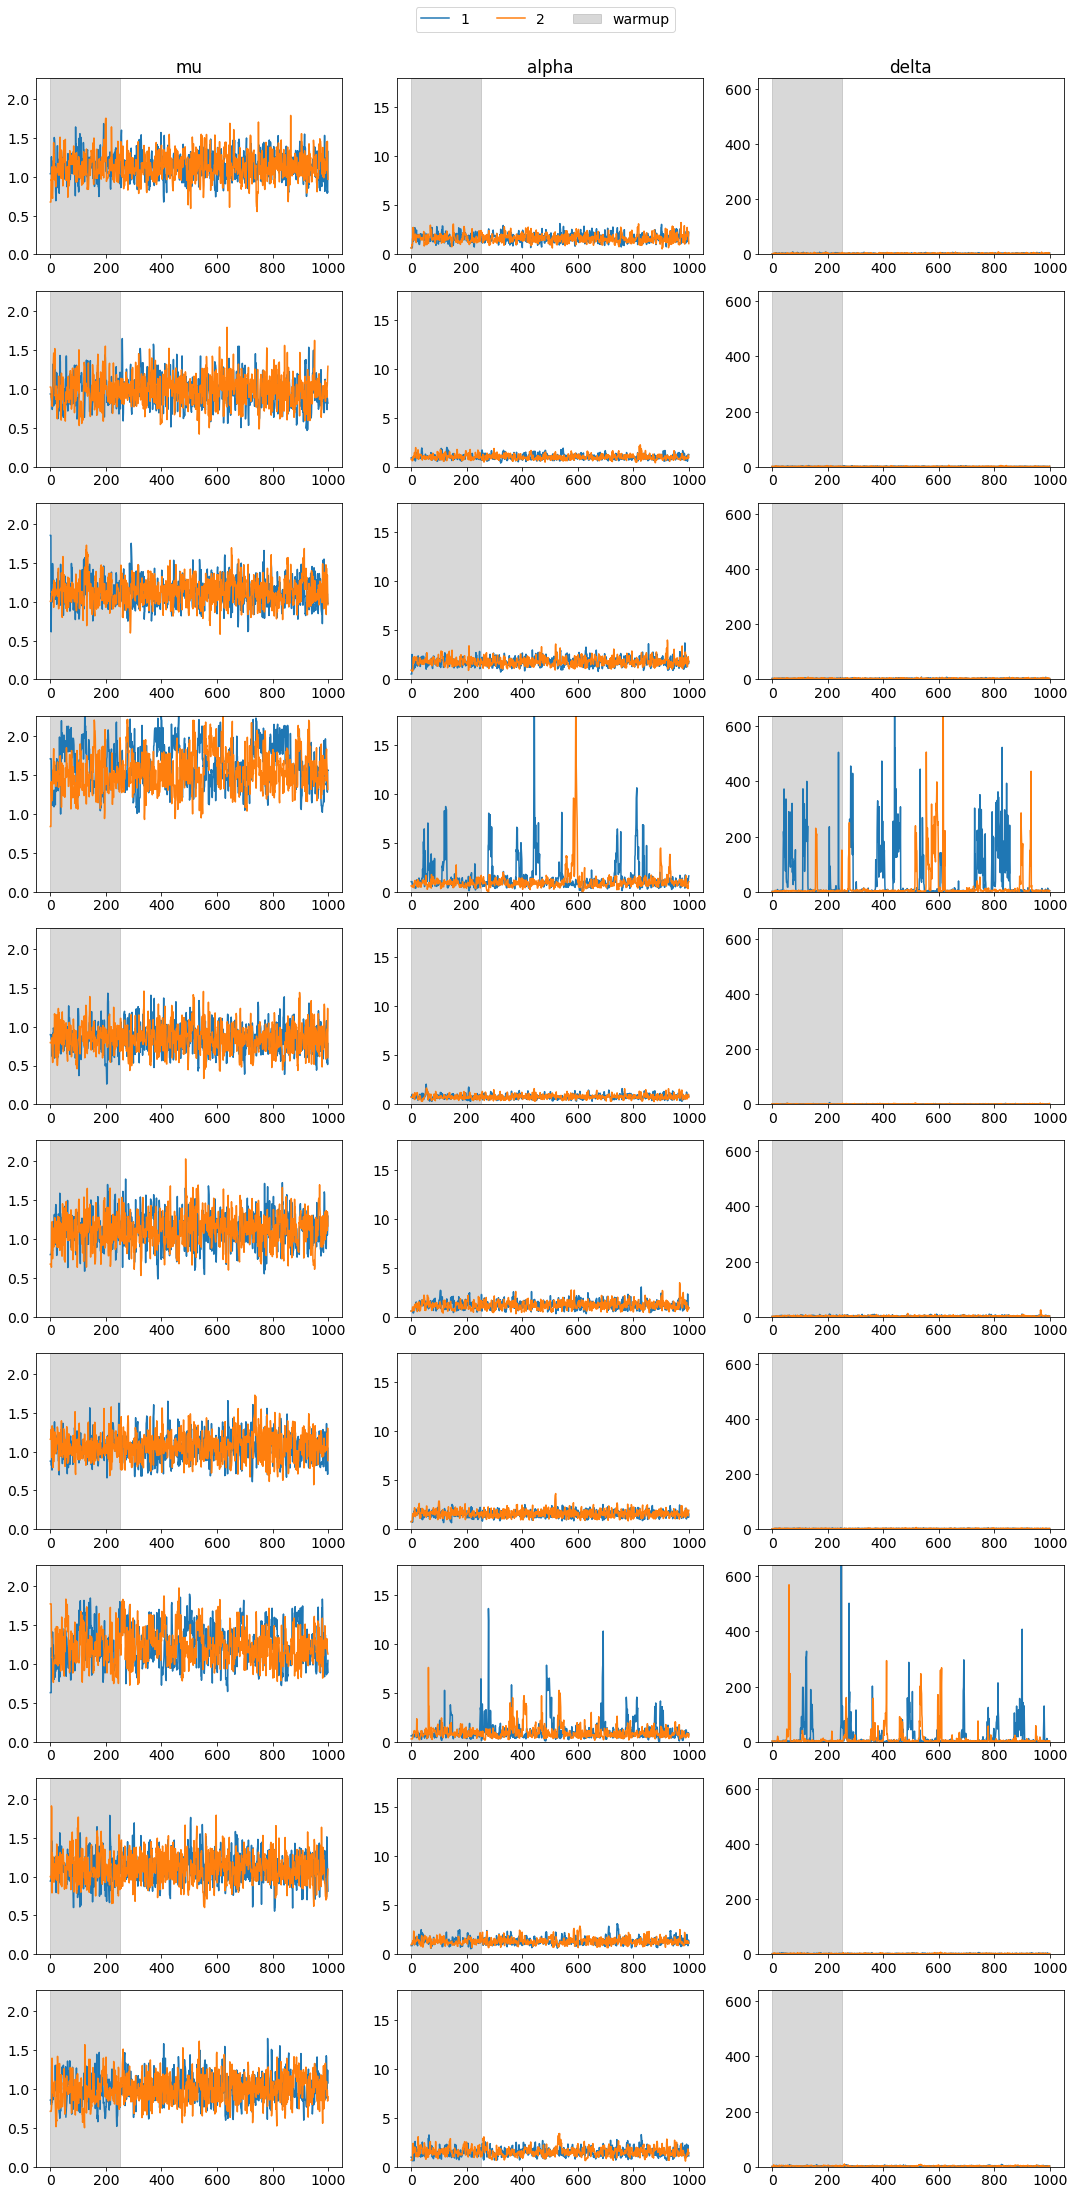

In [206]:
trace_plots(fits, param_strings, warmup=warmup)

In [207]:
mu_prior = lambda x: expon.pdf(x, scale=1/0.01)
alpha_prior = lambda x: expon.pdf(x, scale=1/0.01)
delta_prior = lambda x: expon.pdf(x, scale=1/0.01)

prior_funcs = [mu_prior, alpha_prior, delta_prior]

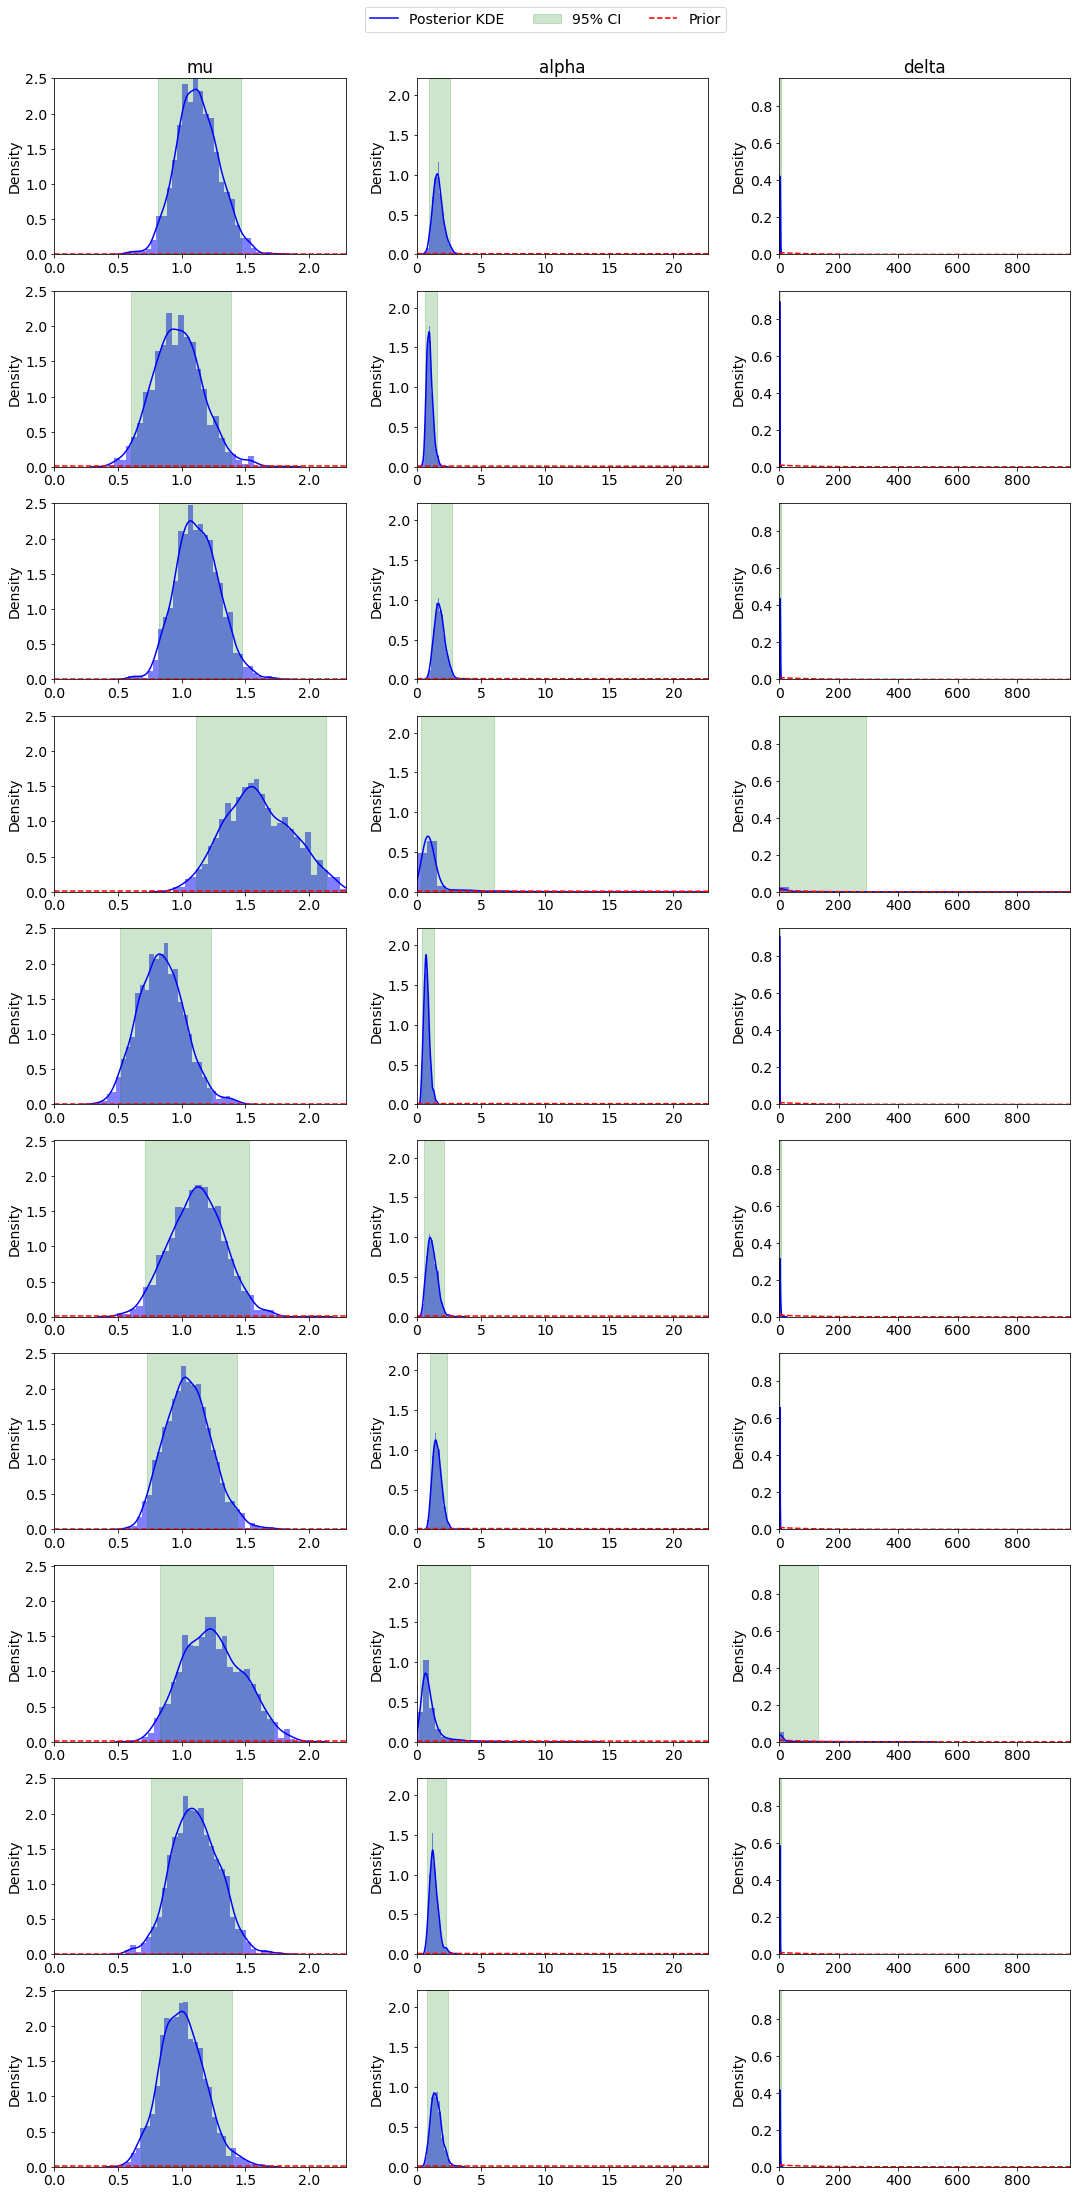

In [208]:
posterior_histograms(fits, param_strings, prior_funcs)

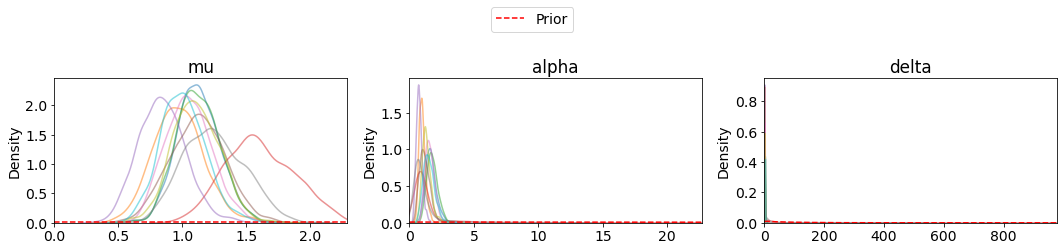

In [209]:
posterior_kdes_overlaid(fits, param_strings, prior_funcs)

In [210]:
mu_prior_ci = stats.expon.interval(0.95, scale=1/0.01)
alpha_prior_ci = stats.expon.interval(0.95, scale=1/0.01)
delta_prior_ci = stats.expon.interval(0.95, scale=1/0.01)

prior_cis = [mu_prior_ci, alpha_prior_ci, delta_prior_ci]

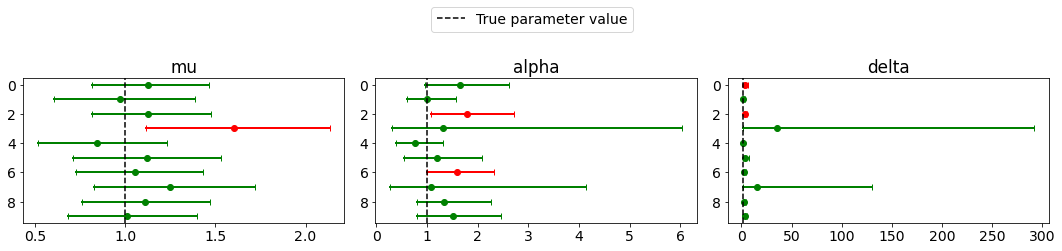

In [216]:
stacked_credible_intervals(fits, param_strings, [1,1,2])

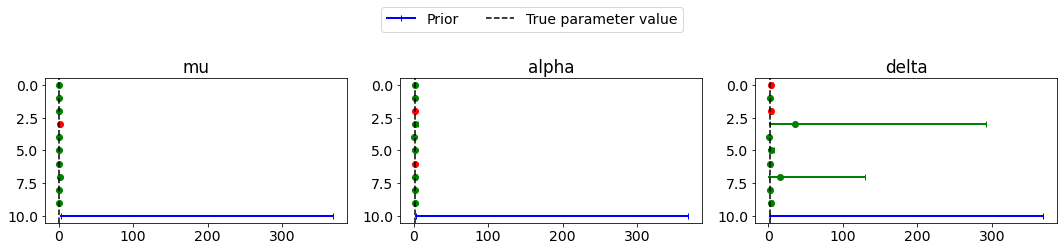

In [217]:
stacked_credible_intervals(fits, param_strings, [1,1,2], prior_cis)

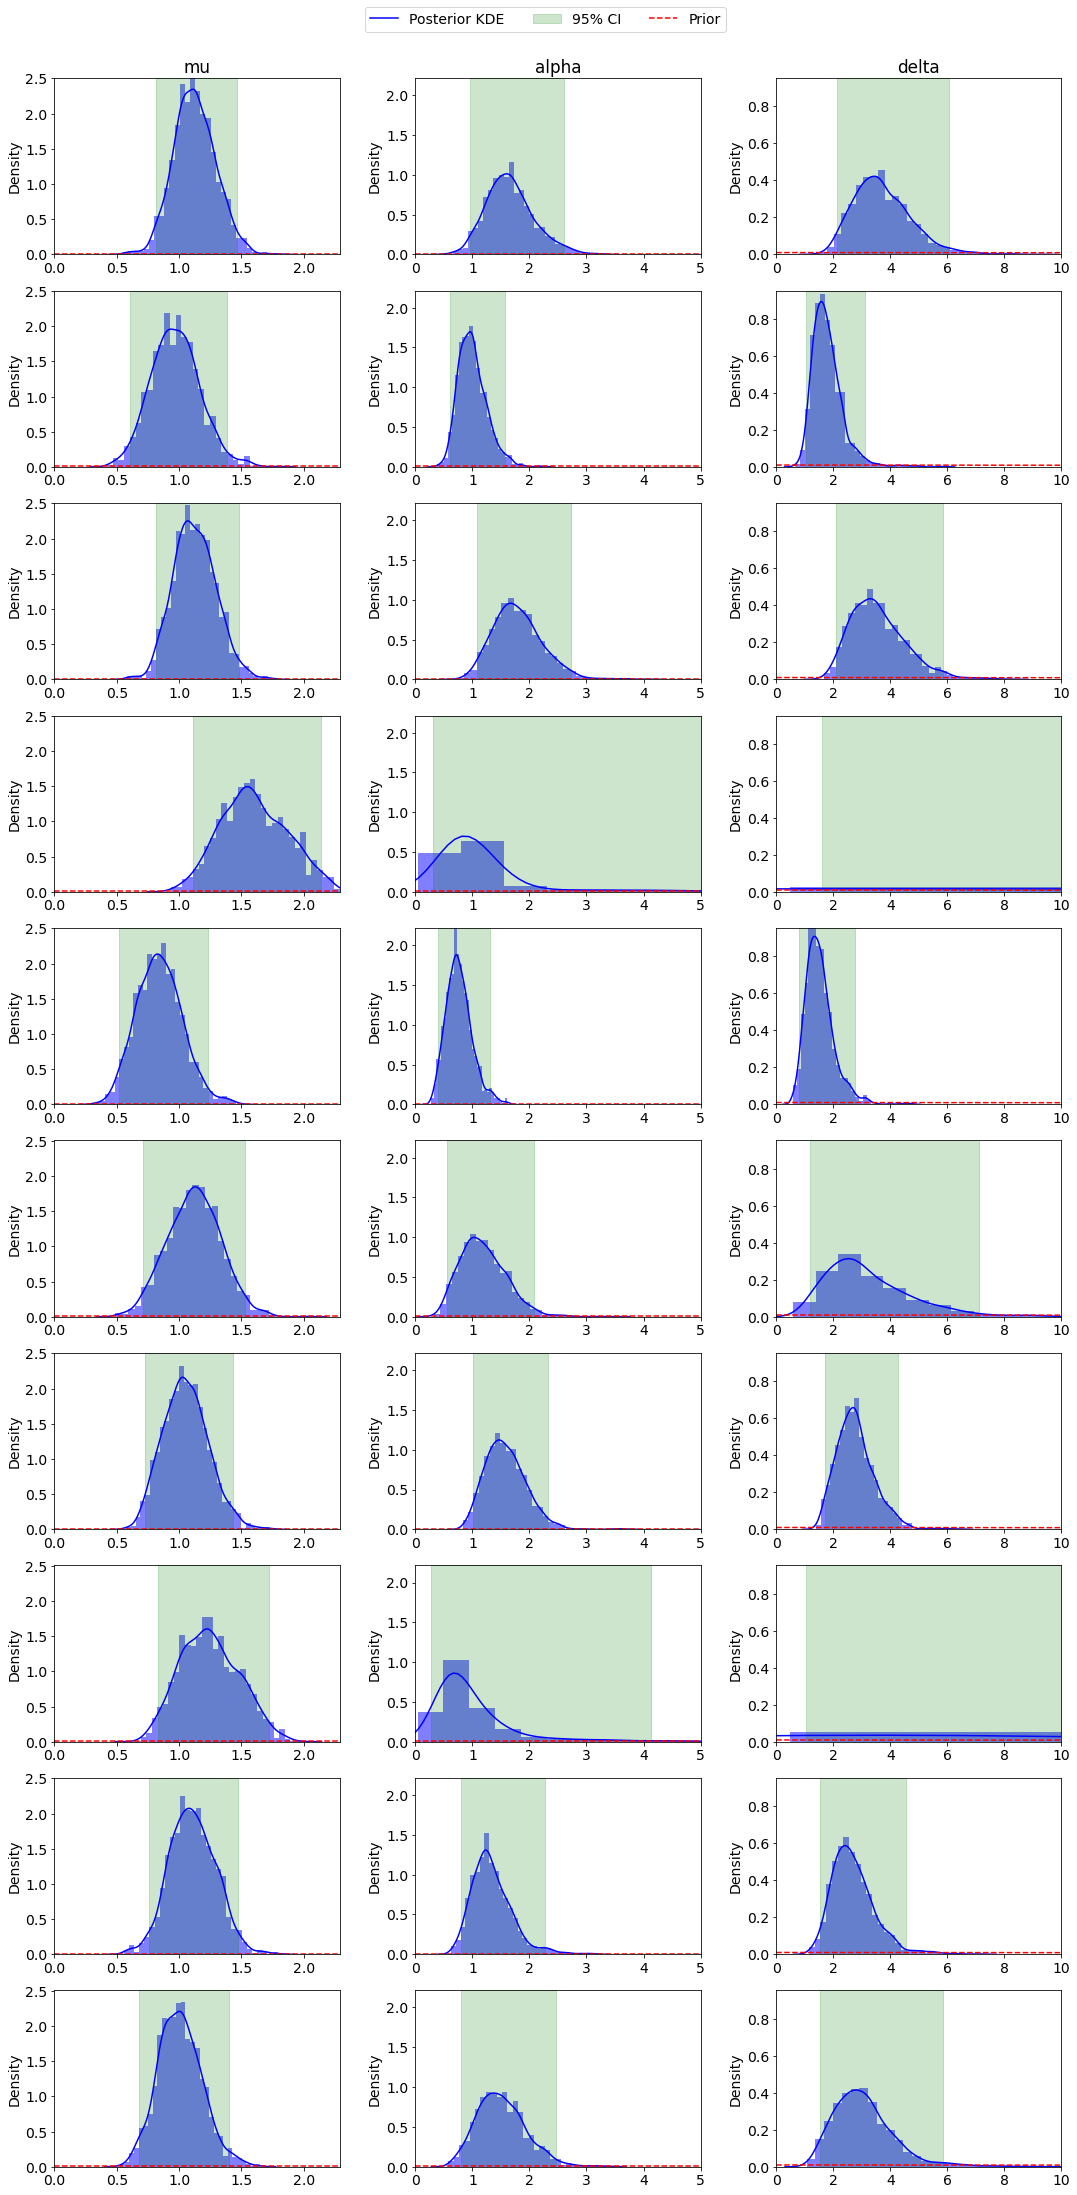

In [218]:
posterior_histograms(fits, param_strings, prior_funcs, xlims=[None, 5, 10])

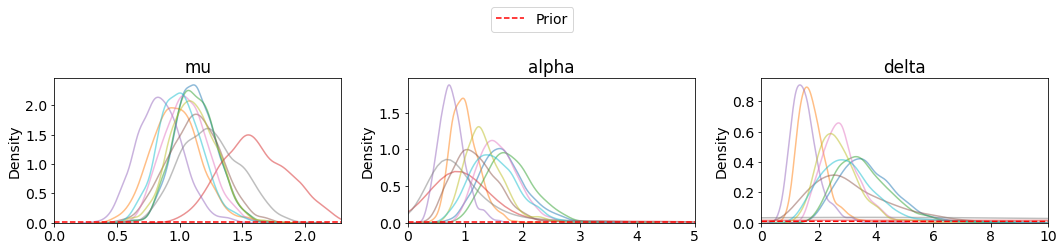

In [219]:
posterior_kdes_overlaid(fits, param_strings, prior_funcs, xlims=[None, 5, 10])

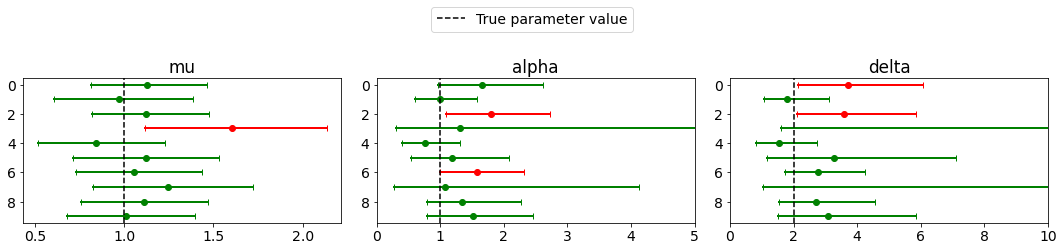

In [227]:
stacked_credible_intervals(fits, param_strings, [1,1,2], xlims=[None, 5, 10])

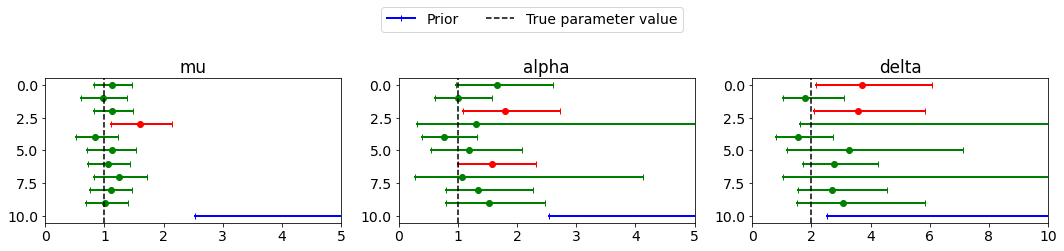

In [228]:
stacked_credible_intervals(fits, param_strings, [1,1,2], prior_cis, xlims=[5, 5, 10])

#### Checking load saved data

We check that we are able to load a Stan fit object successfully from the saved CSV files, and that it matches what it was saved from.

In [189]:
test_path = os.path.join('.','saved_fits','exponential_priors','realisation0')

In [190]:
test_fit = cmdstanpy.from_csv(test_path)

In [191]:
fits[0].summary() == test_fit.summary()

Mean  MCSE  StdDev    5%   50%   95%  N_Eff  N_Eff/s  R_hat
lp__   True  True    True  True  True  True   True     True   True
mu     True  True    True  True  True  True   True     True   True
alpha  True  True    True  True  True  True   True     True   True
delta  True  True    True  True  True  True   True     True   True

In [192]:
np.all(fits[0].draws_pd(inc_warmup=True) == test_fit.draws_pd(inc_warmup=True))

True

### Weakly informative priors - improper Uniform

In [114]:
stan_file = os.path.join('.', 'models', 'improper_uniform_priors.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

14:02:02 - cmdstanpy - INFO - compiling stan file C:\Users\ethan\ONEDRI~1\Maths\YEAR4~1\Project\HAWKES~1\BAYESI~1\models\improper_uniform_priors.stan to exe file C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\improper_uniform_priors.exe
14:03:01 - cmdstanpy - INFO - compiled model executable: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\improper_uniform_priors.exe


In [115]:
warmup = 250

master_seed_stan = 74400201813715236467308085794042177128
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits = []

save_dir = os.path.join('.', 'saved_fits', 'improper_uniform_priors')

for i in range(num_samples):
    print(f"MCMC sampling for realisation {i}")

    child_seed_stan = seed_seq_master_stan.spawn(1)[0]

    # Create a random number generator using the seed
    rng = np.random.default_rng(child_seed_stan)
    
    # Generate random integers less than 2**32 - 1
    child_seed = rng.integers(2**32 - 1)
    print(f"Child seed used = {child_seed}")

    save_path = os.path.join(save_dir, f"realisation{i}")
    print(f"Saving to {save_path}")

    fit = model_compiled.sample(data=data_list[i],
                                seed=child_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True,
                                output_dir=save_path)
    
    fits.append(fit)

14:03:08 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation0
14:03:08 - cmdstanpy - INFO - CmdStan start processing


MCMC sampling for realisation 0
Child seed used = 308621210
Saving to .\saved_fits\improper_uniform_priors\realisation0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:04:34 - cmdstanpy - INFO - CmdStan done processing.
14:04:35 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation1
14:04:35 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 1
Child seed used = 4014884693
Saving to .\saved_fits\improper_uniform_priors\realisation1


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:06:37 - cmdstanpy - INFO - CmdStan done processing.
14:06:37 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation2
14:06:37 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 2
Child seed used = 4154317557
Saving to .\saved_fits\improper_uniform_priors\realisation2


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:07:37 - cmdstanpy - INFO - CmdStan done processing.
14:07:37 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation3
14:07:37 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 3
Child seed used = 796872812
Saving to .\saved_fits\improper_uniform_priors\realisation3


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:17:30 - cmdstanpy - INFO - CmdStan done processing.
14:17:31 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 713 divergent transitions (95.1%)
	Chain 2 had 715 divergent transitions (95.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
14:17:31 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation4
14:17:31 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 4
Child seed used = 2419664284
Saving to .\saved_fits\improper_uniform_priors\realisation4


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:18:48 - cmdstanpy - INFO - CmdStan done processing.
14:18:49 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation5
14:18:49 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 5
Child seed used = 1279310219
Saving to .\saved_fits\improper_uniform_priors\realisation5


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:20:27 - cmdstanpy - INFO - CmdStan done processing.
14:20:27 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation6
14:20:27 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 6
Child seed used = 3359125489
Saving to .\saved_fits\improper_uniform_priors\realisation6


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:22:33 - cmdstanpy - INFO - CmdStan done processing.
14:22:33 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation7
14:22:33 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 7
Child seed used = 1582331695
Saving to .\saved_fits\improper_uniform_priors\realisation7


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:23:33 - cmdstanpy - INFO - CmdStan done processing.
14:23:33 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 672 divergent transitions (89.6%)
	Chain 2 had 726 divergent transitions (96.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
14:23:33 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation8
14:23:33 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 8
Child seed used = 1117257761
Saving to .\saved_fits\improper_uniform_priors\realisation8


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:24:10 - cmdstanpy - INFO - CmdStan done processing.
14:24:10 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation9
14:24:10 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 9
Child seed used = 1370886170
Saving to .\saved_fits\improper_uniform_priors\realisation9


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:24:44 - cmdstanpy - INFO - CmdStan done processing.


In [116]:
for i in range(num_samples):
    print(fits[i].summary())
    print(fits[i].diagnose())

           Mean      MCSE    StdDev  ...    N_Eff  N_Eff/s     R_hat
lp__  -29.53820  0.055538  1.289430  ...  539.022  3.68399  0.999217
mu      1.13020  0.006616  0.174440  ...  695.142  4.75099  1.000520
alpha   1.64411  0.015442  0.413021  ...  715.333  4.88899  1.001660
delta   3.72369  0.039037  1.020930  ...  683.985  4.67474  1.001100

[4 rows x 9 columns]
Processing csv files: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation0\improper_uniform_priors-20240425140308_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\improper_uniform_priors\realisation0\improper_uniform_priors-20240425140308_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergenc

In [117]:
trace_plots(fits, param_strings, warmup=warmup)

C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\ticker.py:2096: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\ticker.py:2131: RuntimeWarning: overflow encountered in multiply
  ticks = np.arange(low, high + 1) * step + best_vmin


OverflowError: cannot convert float infinity to integer

Error in callback <function _draw_all_if_interactive at 0x000001C2D8B5F9C0> (for post_execute), with arguments args (),kwargs {}:


OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

<Figure size 1080x2160 with 30 Axes>

In [118]:
mu_prior = lambda x: expon.pdf(x, scale=1/0.01)
alpha_prior = lambda x: expon.pdf(x, scale=1/0.01)
delta_prior = lambda x: expon.pdf(x, scale=1/0.01)

prior_funcs = [mu_prior, alpha_prior, delta_prior]

C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


ValueError: array must not contain infs or NaNs

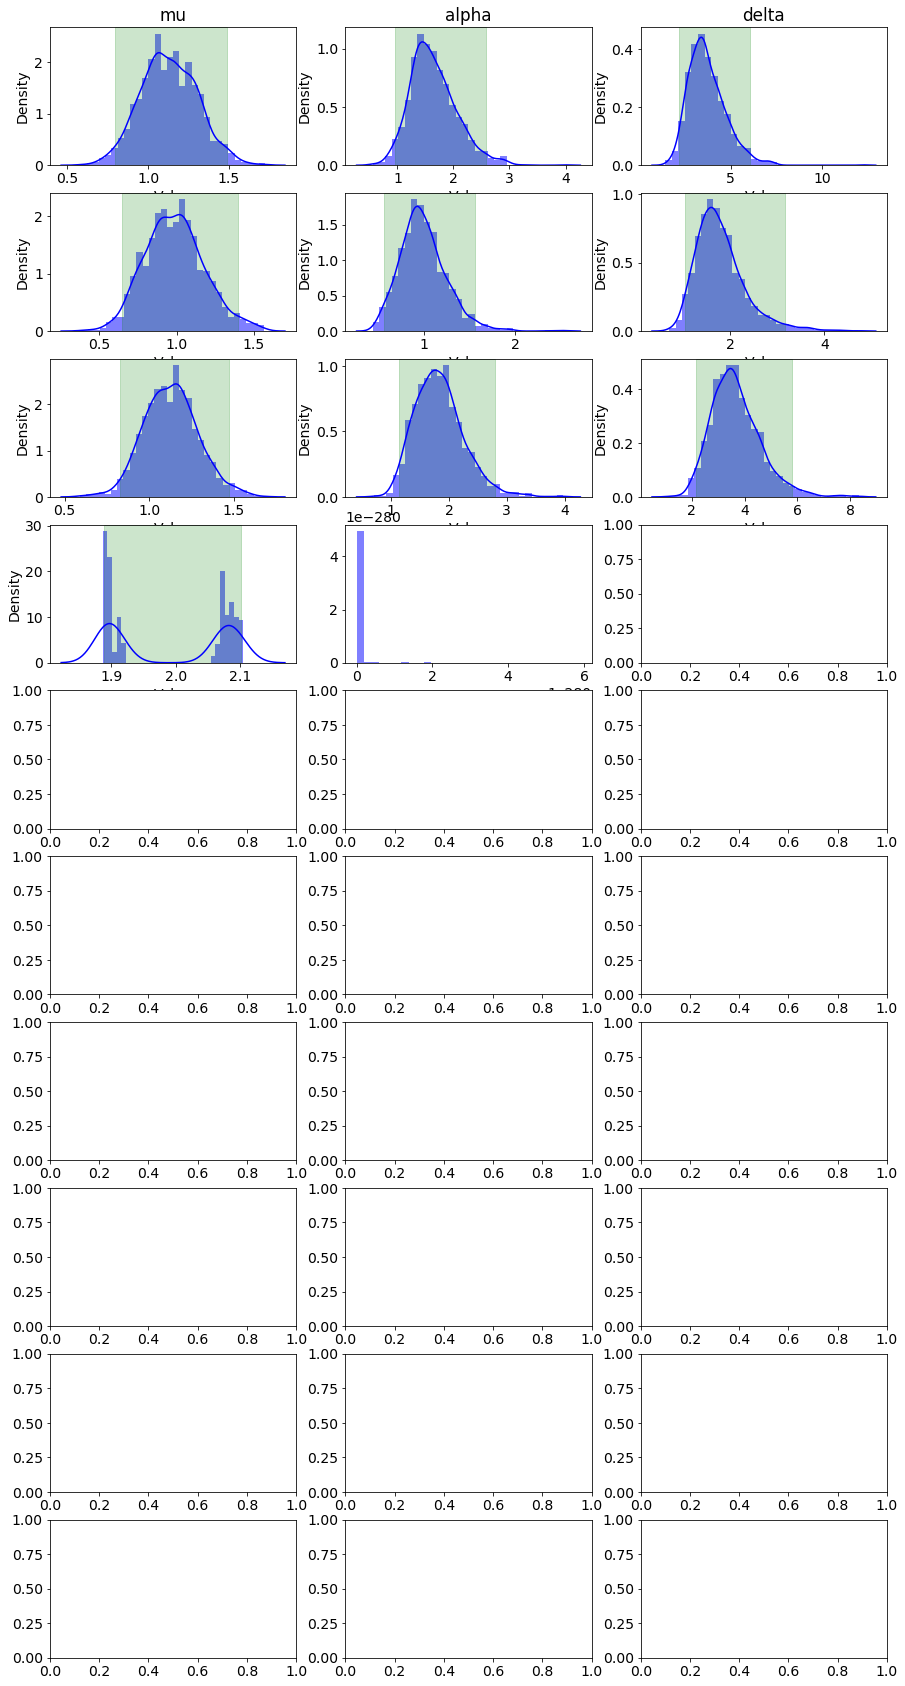

In [119]:
posterior_histograms(fits, param_strings, prior_funcs)

C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


ValueError: array must not contain infs or NaNs

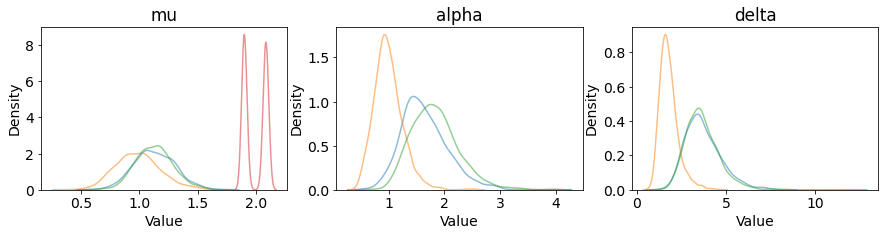

In [120]:
posterior_kdes_overlaid(fits, param_strings, prior_funcs)

In [121]:
mu_prior_ci = stats.expon.interval(0.95, scale=1/0.01)
alpha_prior_ci = stats.expon.interval(0.95, scale=1/0.01)
delta_prior_ci = stats.expon.interval(0.95, scale=1/0.01)

prior_cis = [mu_prior_ci, alpha_prior_ci, delta_prior_ci]

C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\ethan\anaconda3\e

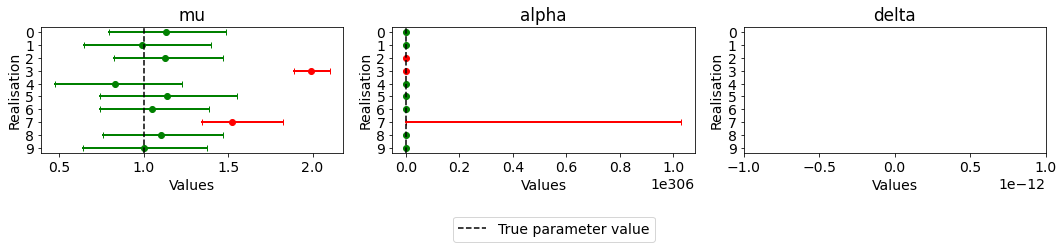

In [122]:
stacked_credible_intervals(fits, param_strings, [1,1,2])

C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\ethan\anaconda3\e

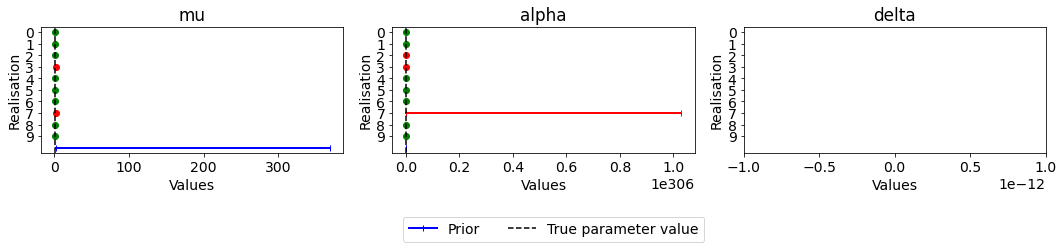

In [123]:
stacked_credible_intervals(fits, param_strings, [1,1,2], prior_cis)

C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


ValueError: array must not contain infs or NaNs

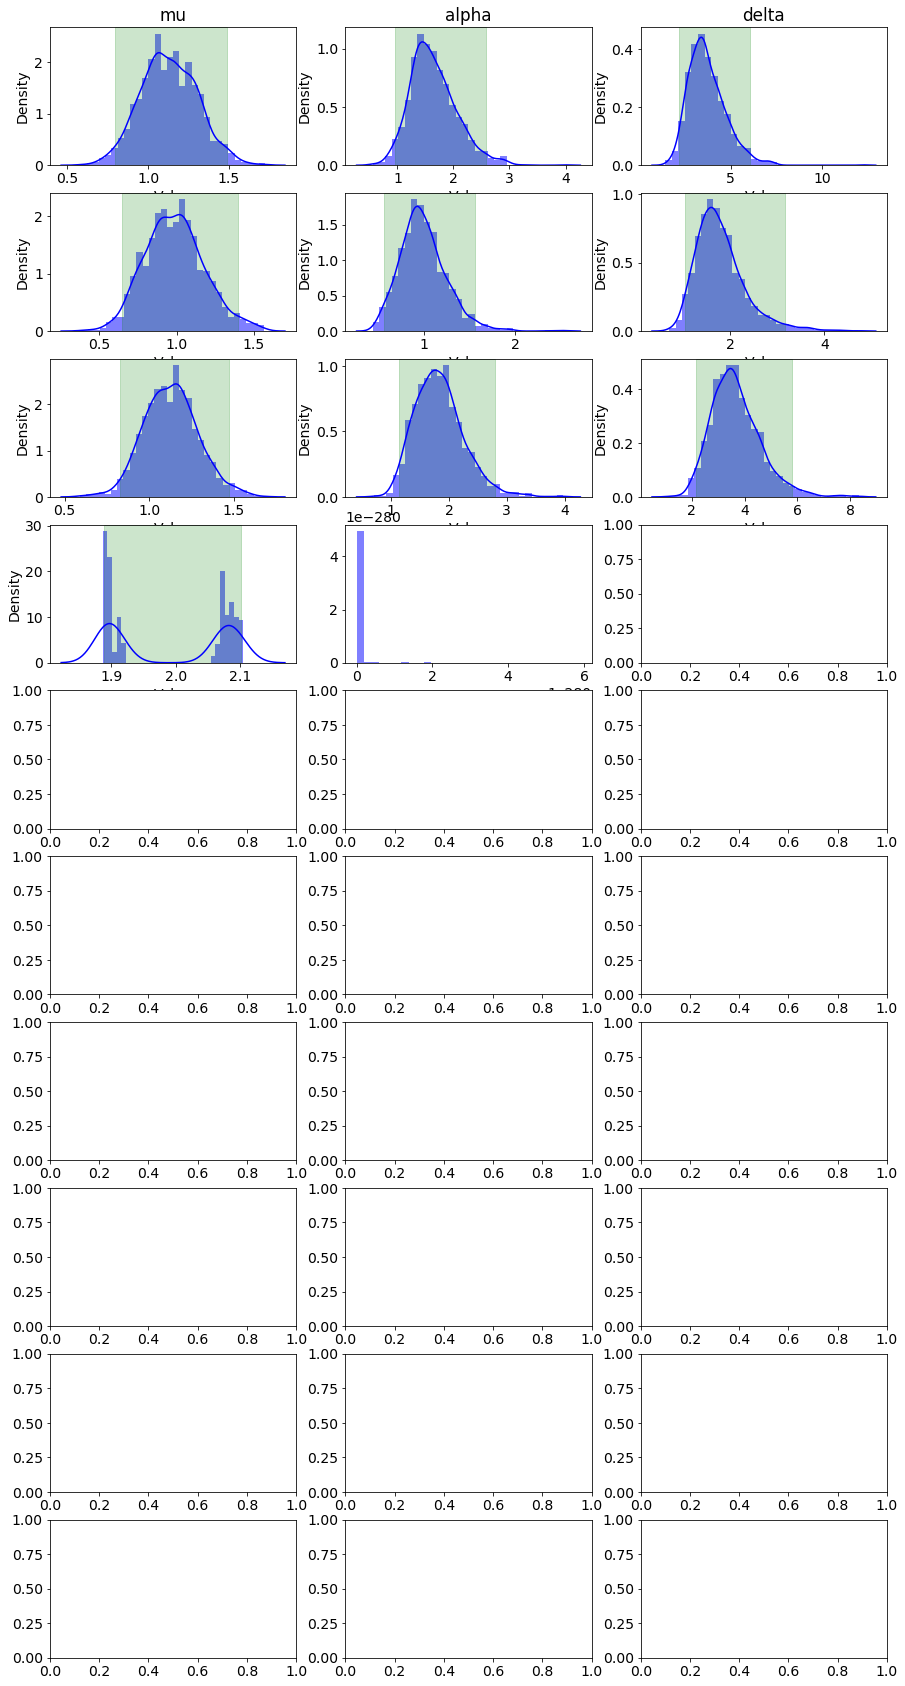

In [124]:
posterior_histograms(fits, param_strings, prior_funcs, xlims=[None, 5, 10])

In [ ]:
posterior_kdes_overlaid(fits, param_strings, prior_funcs, xlims=[None, 5, 10])

C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\ethan\anaconda3\e

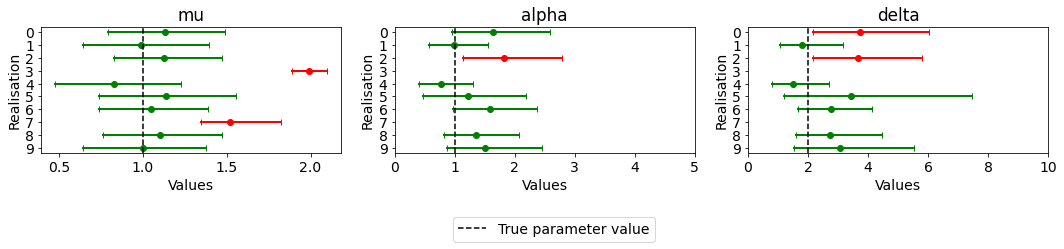

In [125]:
stacked_credible_intervals(fits, param_strings, [1,1,2], xlims=[None, 5, 10])

C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\ethan\anaconda3\envs\test\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\ethan\anaconda3\e

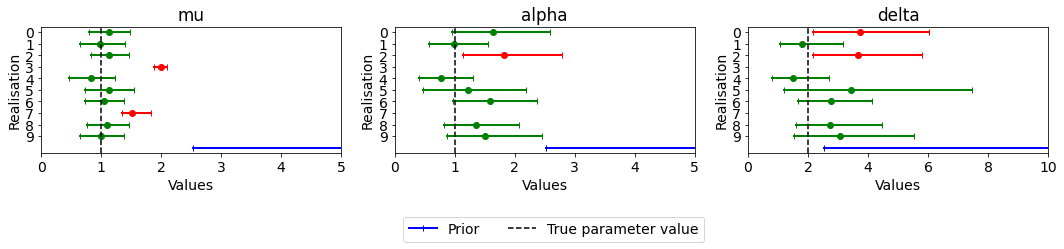

In [126]:
stacked_credible_intervals(fits, param_strings, [1,1,2], prior_cis, xlims=[5, 5, 10])

### Weakly informative priors - Uniform(0, 1e6)

In [127]:
stan_file = os.path.join('.', 'models', 'uniform_priors.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

14:31:45 - cmdstanpy - INFO - compiling stan file C:\Users\ethan\ONEDRI~1\Maths\YEAR4~1\Project\HAWKES~1\BAYESI~1\models\uniform_priors.stan to exe file C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\uniform_priors.exe
14:32:07 - cmdstanpy - INFO - compiled model executable: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\uniform_priors.exe


In [128]:
warmup = 250

master_seed_stan = 74400201813715236467308085794042177128
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits = []

save_dir = os.path.join('.', 'saved_fits', 'uniform_priors')

for i in range(num_samples):
    print(f"MCMC sampling for realisation {i}")

    child_seed_stan = seed_seq_master_stan.spawn(1)[0]

    # Create a random number generator using the seed
    rng = np.random.default_rng(child_seed_stan)
    
    # Generate random integers less than 2**32 - 1
    child_seed = rng.integers(2**32 - 1)
    print(f"Child seed used = {child_seed}")

    save_path = os.path.join(save_dir, f"realisation{i}")
    print(f"Saving to {save_path}")

    fit = model_compiled.sample(data=data_list[i],
                                seed=child_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True,
                                output_dir=save_path)
    
    fits.append(fit)

14:34:48 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation0
14:34:48 - cmdstanpy - INFO - CmdStan start processing


MCMC sampling for realisation 0
Child seed used = 308621210
Saving to .\saved_fits\uniform_priors\realisation0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:36:22 - cmdstanpy - INFO - CmdStan done processing.
14:36:22 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation1
14:36:22 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 1
Child seed used = 4014884693
Saving to .\saved_fits\uniform_priors\realisation1


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:38:58 - cmdstanpy - INFO - CmdStan done processing.
14:38:59 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation2
14:38:59 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 2
Child seed used = 4154317557
Saving to .\saved_fits\uniform_priors\realisation2


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:40:43 - cmdstanpy - INFO - CmdStan done processing.


14:40:44 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation3
14:40:44 - cmdstanpy - INFO - CmdStan start processing


MCMC sampling for realisation 3
Child seed used = 796872812
Saving to .\saved_fits\uniform_priors\realisation3


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:42:13 - cmdstanpy - INFO - CmdStan done processing.
14:42:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 711 divergent transitions (94.8%)
	Chain 2 had 544 divergent transitions (72.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
14:42:13 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation4
14:42:13 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 4
Child seed used = 2419664284
Saving to .\saved_fits\uniform_priors\realisation4


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:43:16 - cmdstanpy - INFO - CmdStan done processing.
14:43:16 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation5
14:43:16 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 5
Child seed used = 1279310219
Saving to .\saved_fits\uniform_priors\realisation5


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:45:25 - cmdstanpy - INFO - CmdStan done processing.
14:45:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 603 divergent transitions (80.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
14:45:25 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation6
14:45:26 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 6
Child seed used = 3359125489
Saving to .\saved_fits\uniform_priors\realisation6


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:47:54 - cmdstanpy - INFO - CmdStan done processing.
14:47:55 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation7
14:47:55 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 7
Child seed used = 1582331695
Saving to .\saved_fits\uniform_priors\realisation7


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:50:43 - cmdstanpy - INFO - CmdStan done processing.
14:50:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 472 divergent transitions (62.9%)
	Chain 2 had 591 divergent transitions (78.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
14:50:43 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation8
14:50:43 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 8
Child seed used = 1117257761
Saving to .\saved_fits\uniform_priors\realisation8


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:52:55 - cmdstanpy - INFO - CmdStan done processing.
14:52:55 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation9
14:52:55 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 9
Child seed used = 1370886170
Saving to .\saved_fits\uniform_priors\realisation9


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

14:54:47 - cmdstanpy - INFO - CmdStan done processing.


In [129]:
for i in range(num_samples):
    print(fits[i].summary())
    print(fits[i].diagnose())

           Mean      MCSE    StdDev  ...    N_Eff  N_Eff/s     R_hat
lp__  -29.53820  0.055538  1.289430  ...  539.022  3.23281  0.999217
mu      1.13020  0.006616  0.174440  ...  695.142  4.16914  1.000520
alpha   1.64411  0.015442  0.413021  ...  715.333  4.29024  1.001660
delta   3.72369  0.039037  1.020930  ...  683.985  4.10223  1.001100

[4 rows x 9 columns]
Processing csv files: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation0\uniform_priors-20240425143448_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\uniform_priors\realisation0\uniform_priors-20240425143448_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.


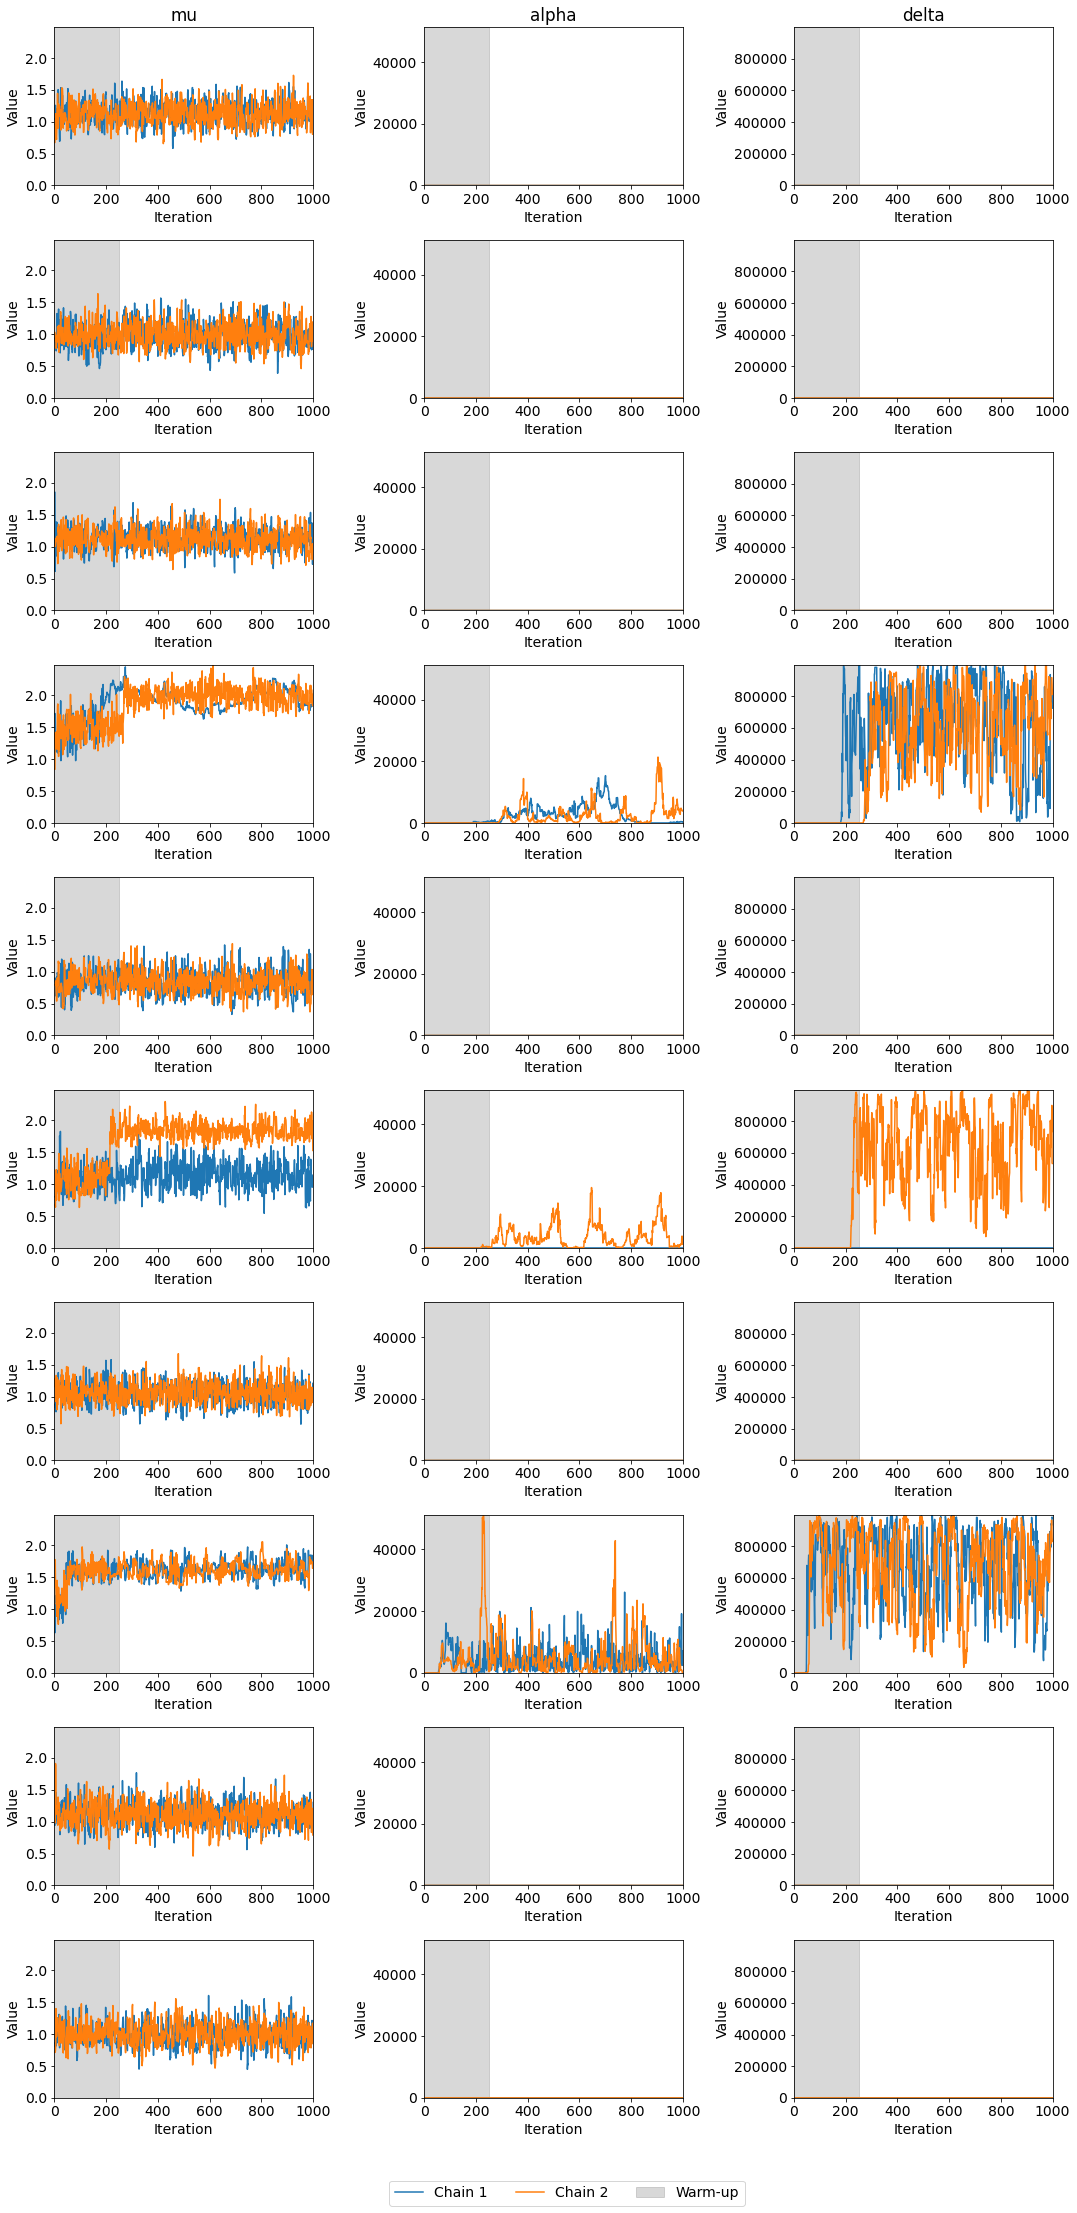

In [130]:
trace_plots(fits, param_strings, warmup=warmup)

In [131]:
mu_prior = lambda x: expon.pdf(x, scale=1/0.01)
alpha_prior = lambda x: expon.pdf(x, scale=1/0.01)
delta_prior = lambda x: expon.pdf(x, scale=1/0.01)

prior_funcs = [mu_prior, alpha_prior, delta_prior]

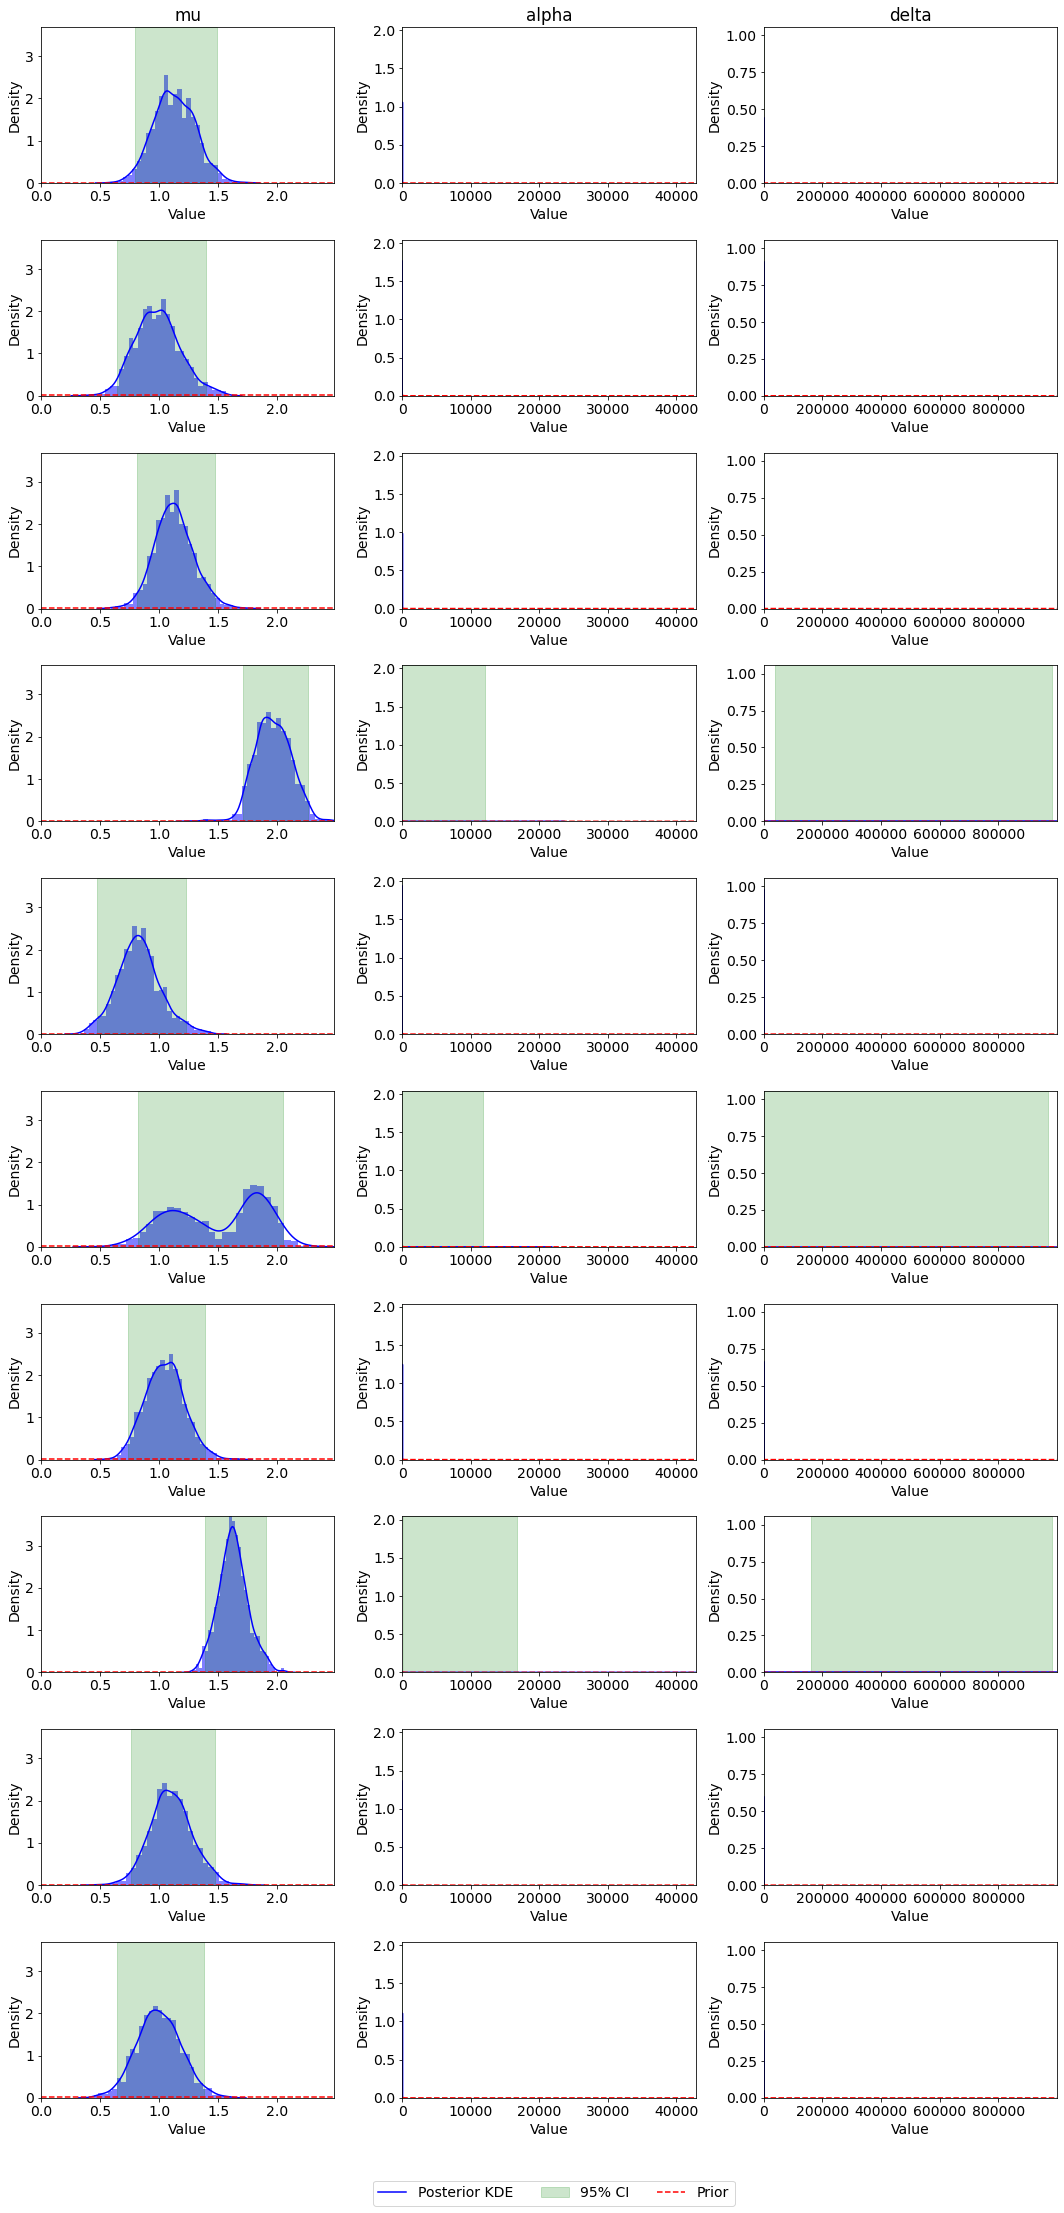

In [132]:
posterior_histograms(fits, param_strings, prior_funcs)

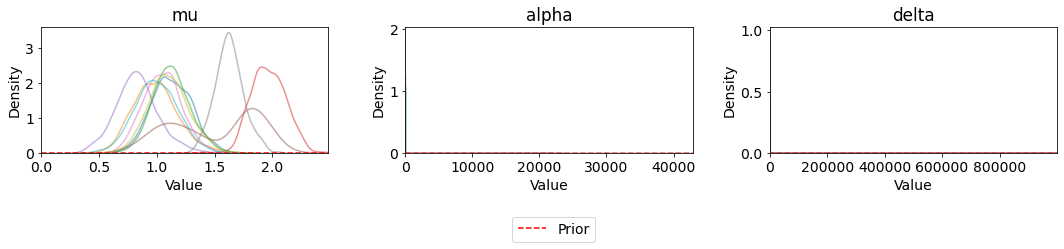

In [133]:
posterior_kdes_overlaid(fits, param_strings, prior_funcs)

In [134]:
mu_prior_ci = stats.expon.interval(0.95, scale=1/0.01)
alpha_prior_ci = stats.expon.interval(0.95, scale=1/0.01)
delta_prior_ci = stats.expon.interval(0.95, scale=1/0.01)

prior_cis = [mu_prior_ci, alpha_prior_ci, delta_prior_ci]

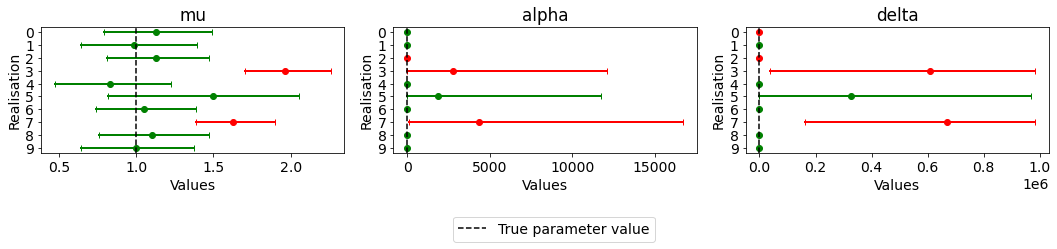

In [135]:
stacked_credible_intervals(fits, param_strings, [1,1,2])

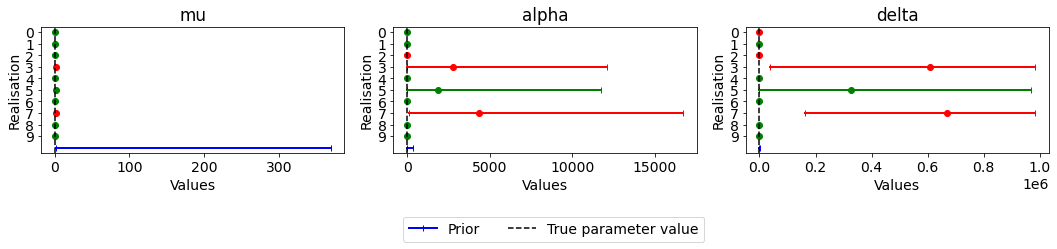

In [136]:
stacked_credible_intervals(fits, param_strings, [1,1,2], prior_cis)

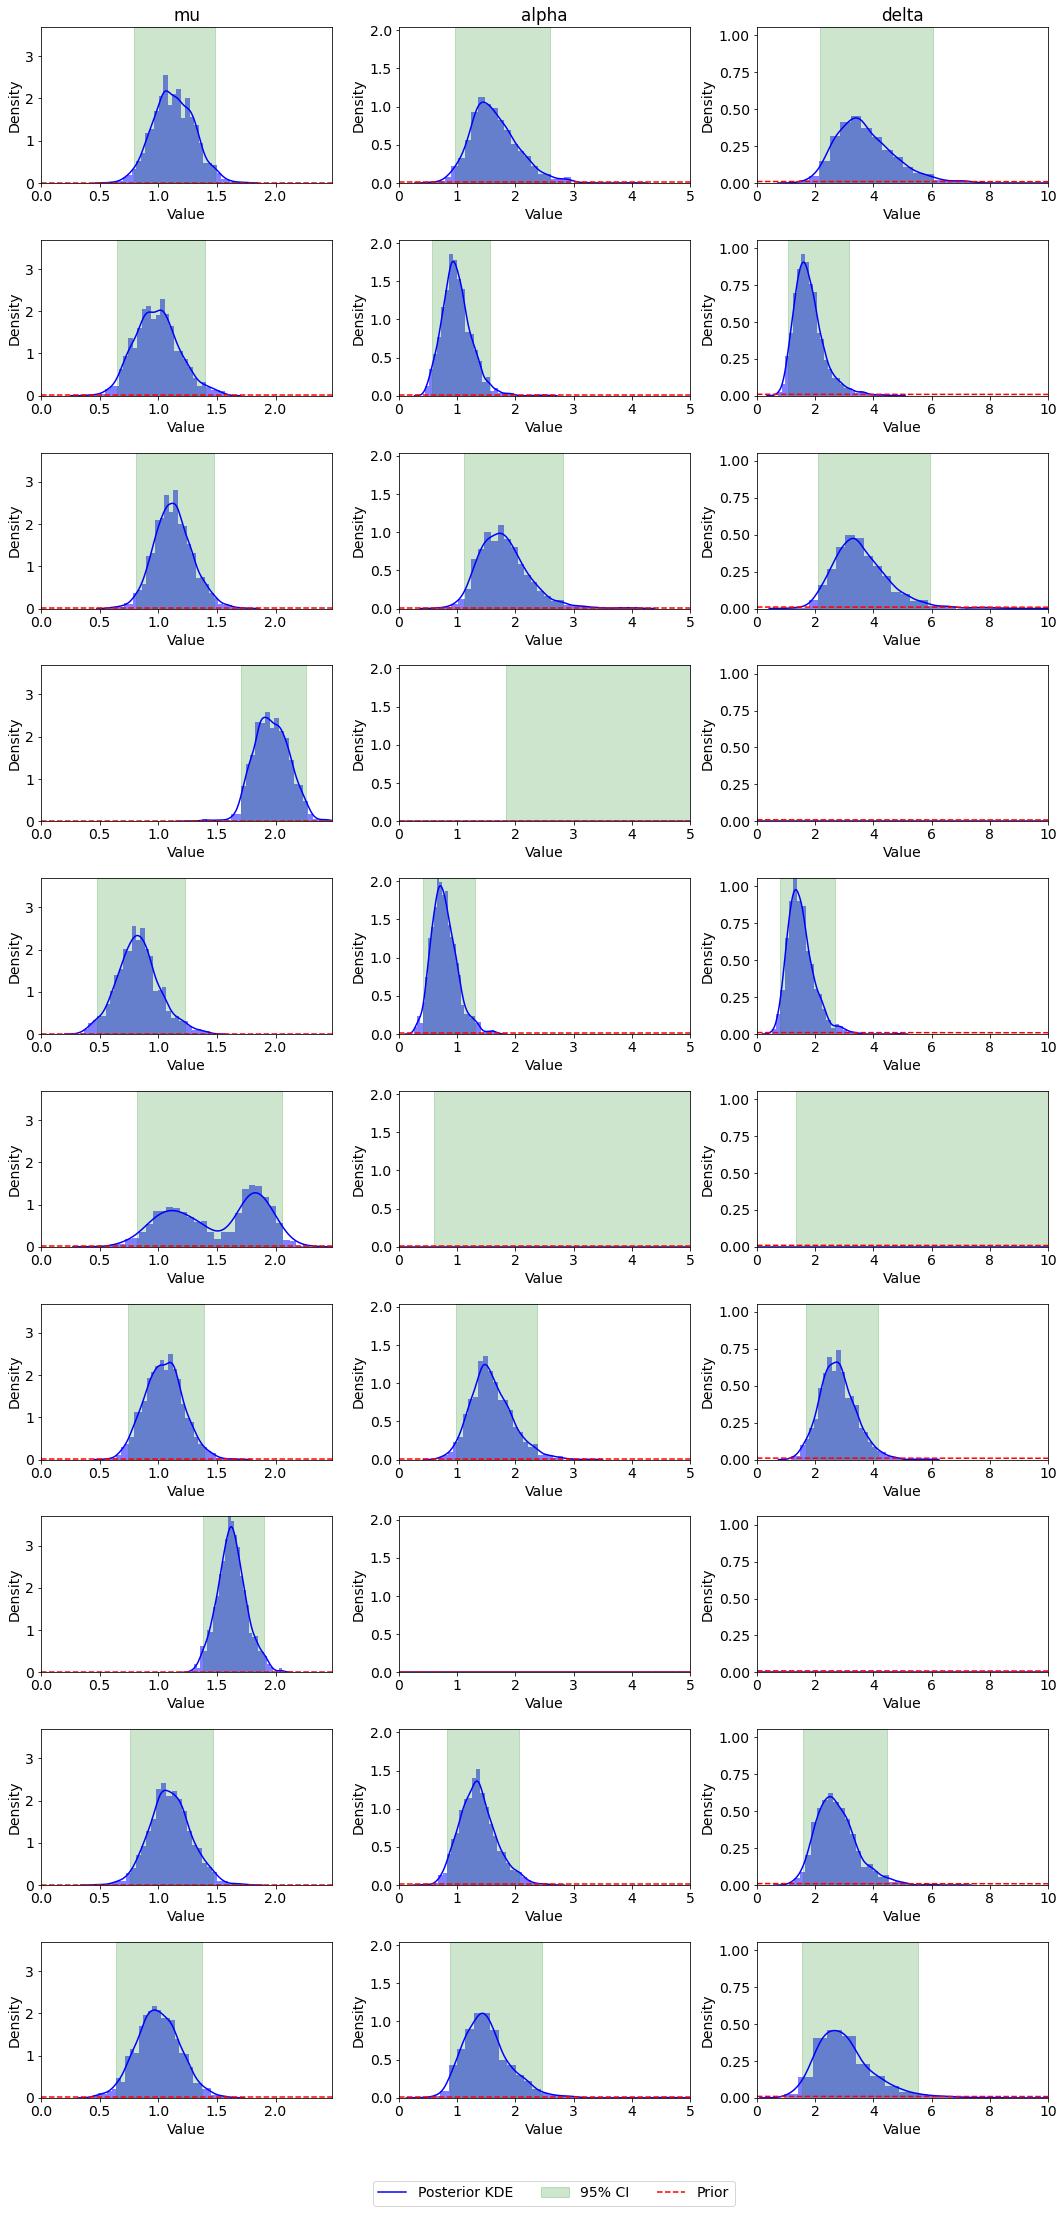

In [137]:
posterior_histograms(fits, param_strings, prior_funcs, xlims=[None, 5, 10])

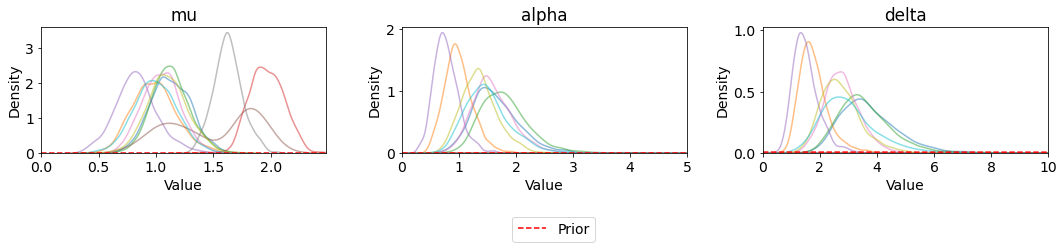

In [138]:
posterior_kdes_overlaid(fits, param_strings, prior_funcs, xlims=[None, 5, 10])

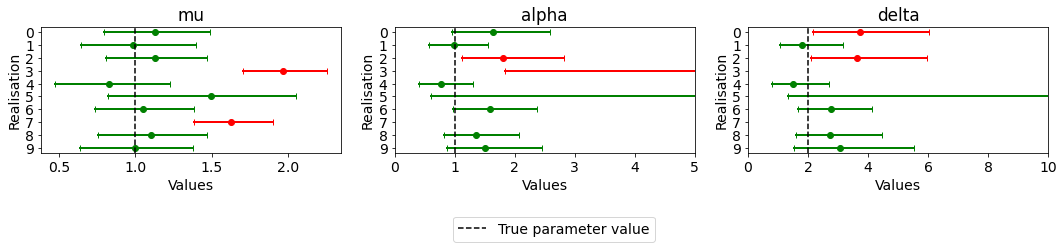

In [139]:
stacked_credible_intervals(fits, param_strings, [1,1,2], xlims=[None, 5, 10])

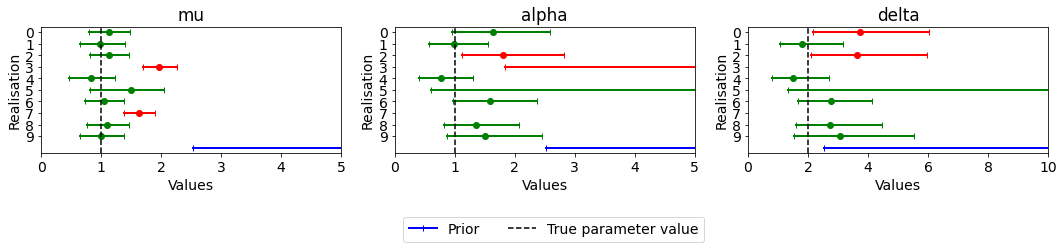

In [140]:
stacked_credible_intervals(fits, param_strings, [1,1,2], prior_cis, xlims=[5, 5, 10])